In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import minimize
import scipy

In [65]:
print(dt)

0.001


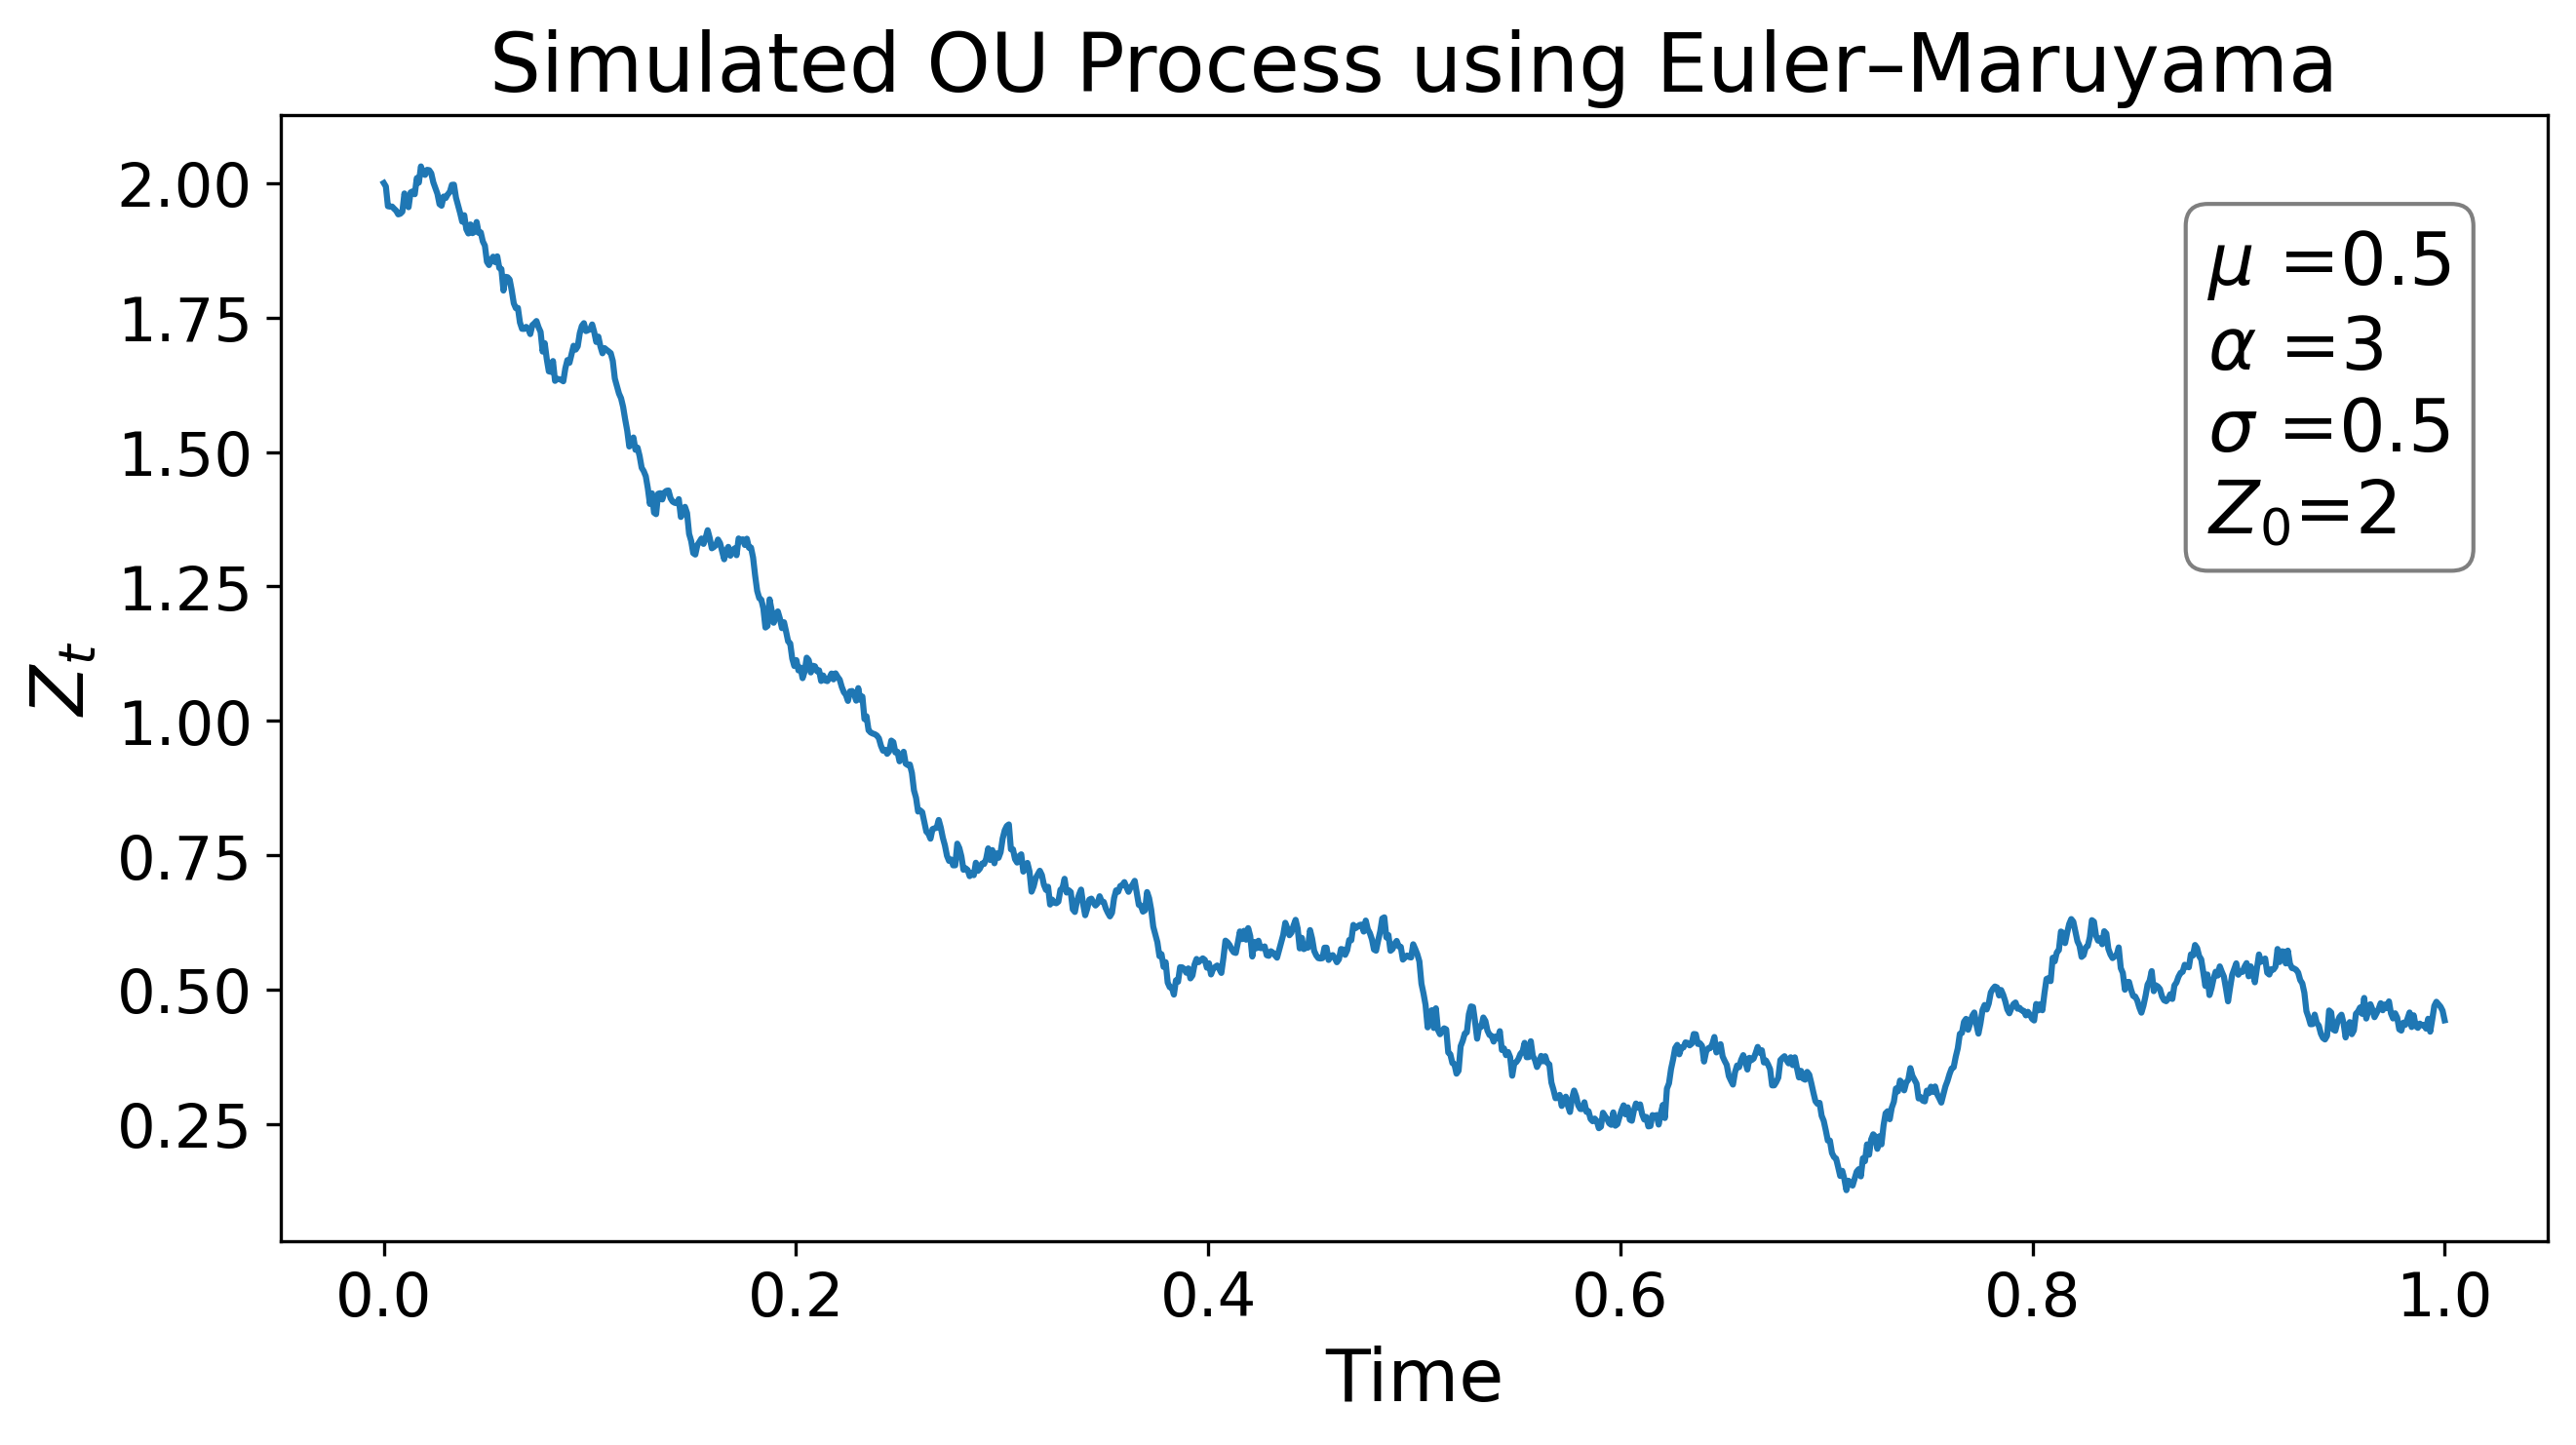

In [287]:
# simulate an OU process using the EM method
np.random.seed(seed=306)

# model parameters
alpha = 3
mu = 0.5
sigma = 0.5
Z0 = 2  

# simulation parameters
T = 1 
N = 1000
dt = T / N     
time = np.linspace(0, T, N)
Zt = np.zeros(N)

Zt[0] = Z0

# EM steps
for t in range(1, N):
    dW = np.random.normal(0,np.sqrt(dt)) 
    Zt[t] = Zt[t-1] + alpha * (mu - Zt[t-1]) * dt + sigma * dW

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(time, Zt)
plt.title('Simulated OU Process using Euler–Maruyama', size=20)
plt.xlabel('Time', size=18)
plt.ylabel(r'$Z_t$', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.85, 0.9, r'$\mu$ ='+str(mu)+"\n"+r'$\alpha$ ='+str(alpha)+"\n"+r'$\sigma$ ='+str(sigma)+"\n"+r'$Z_0$='+str(Z0), transform=plt.gca().transAxes, fontsize=18,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig("ou-process.svg",bbox_inches='tight')
plt.show()

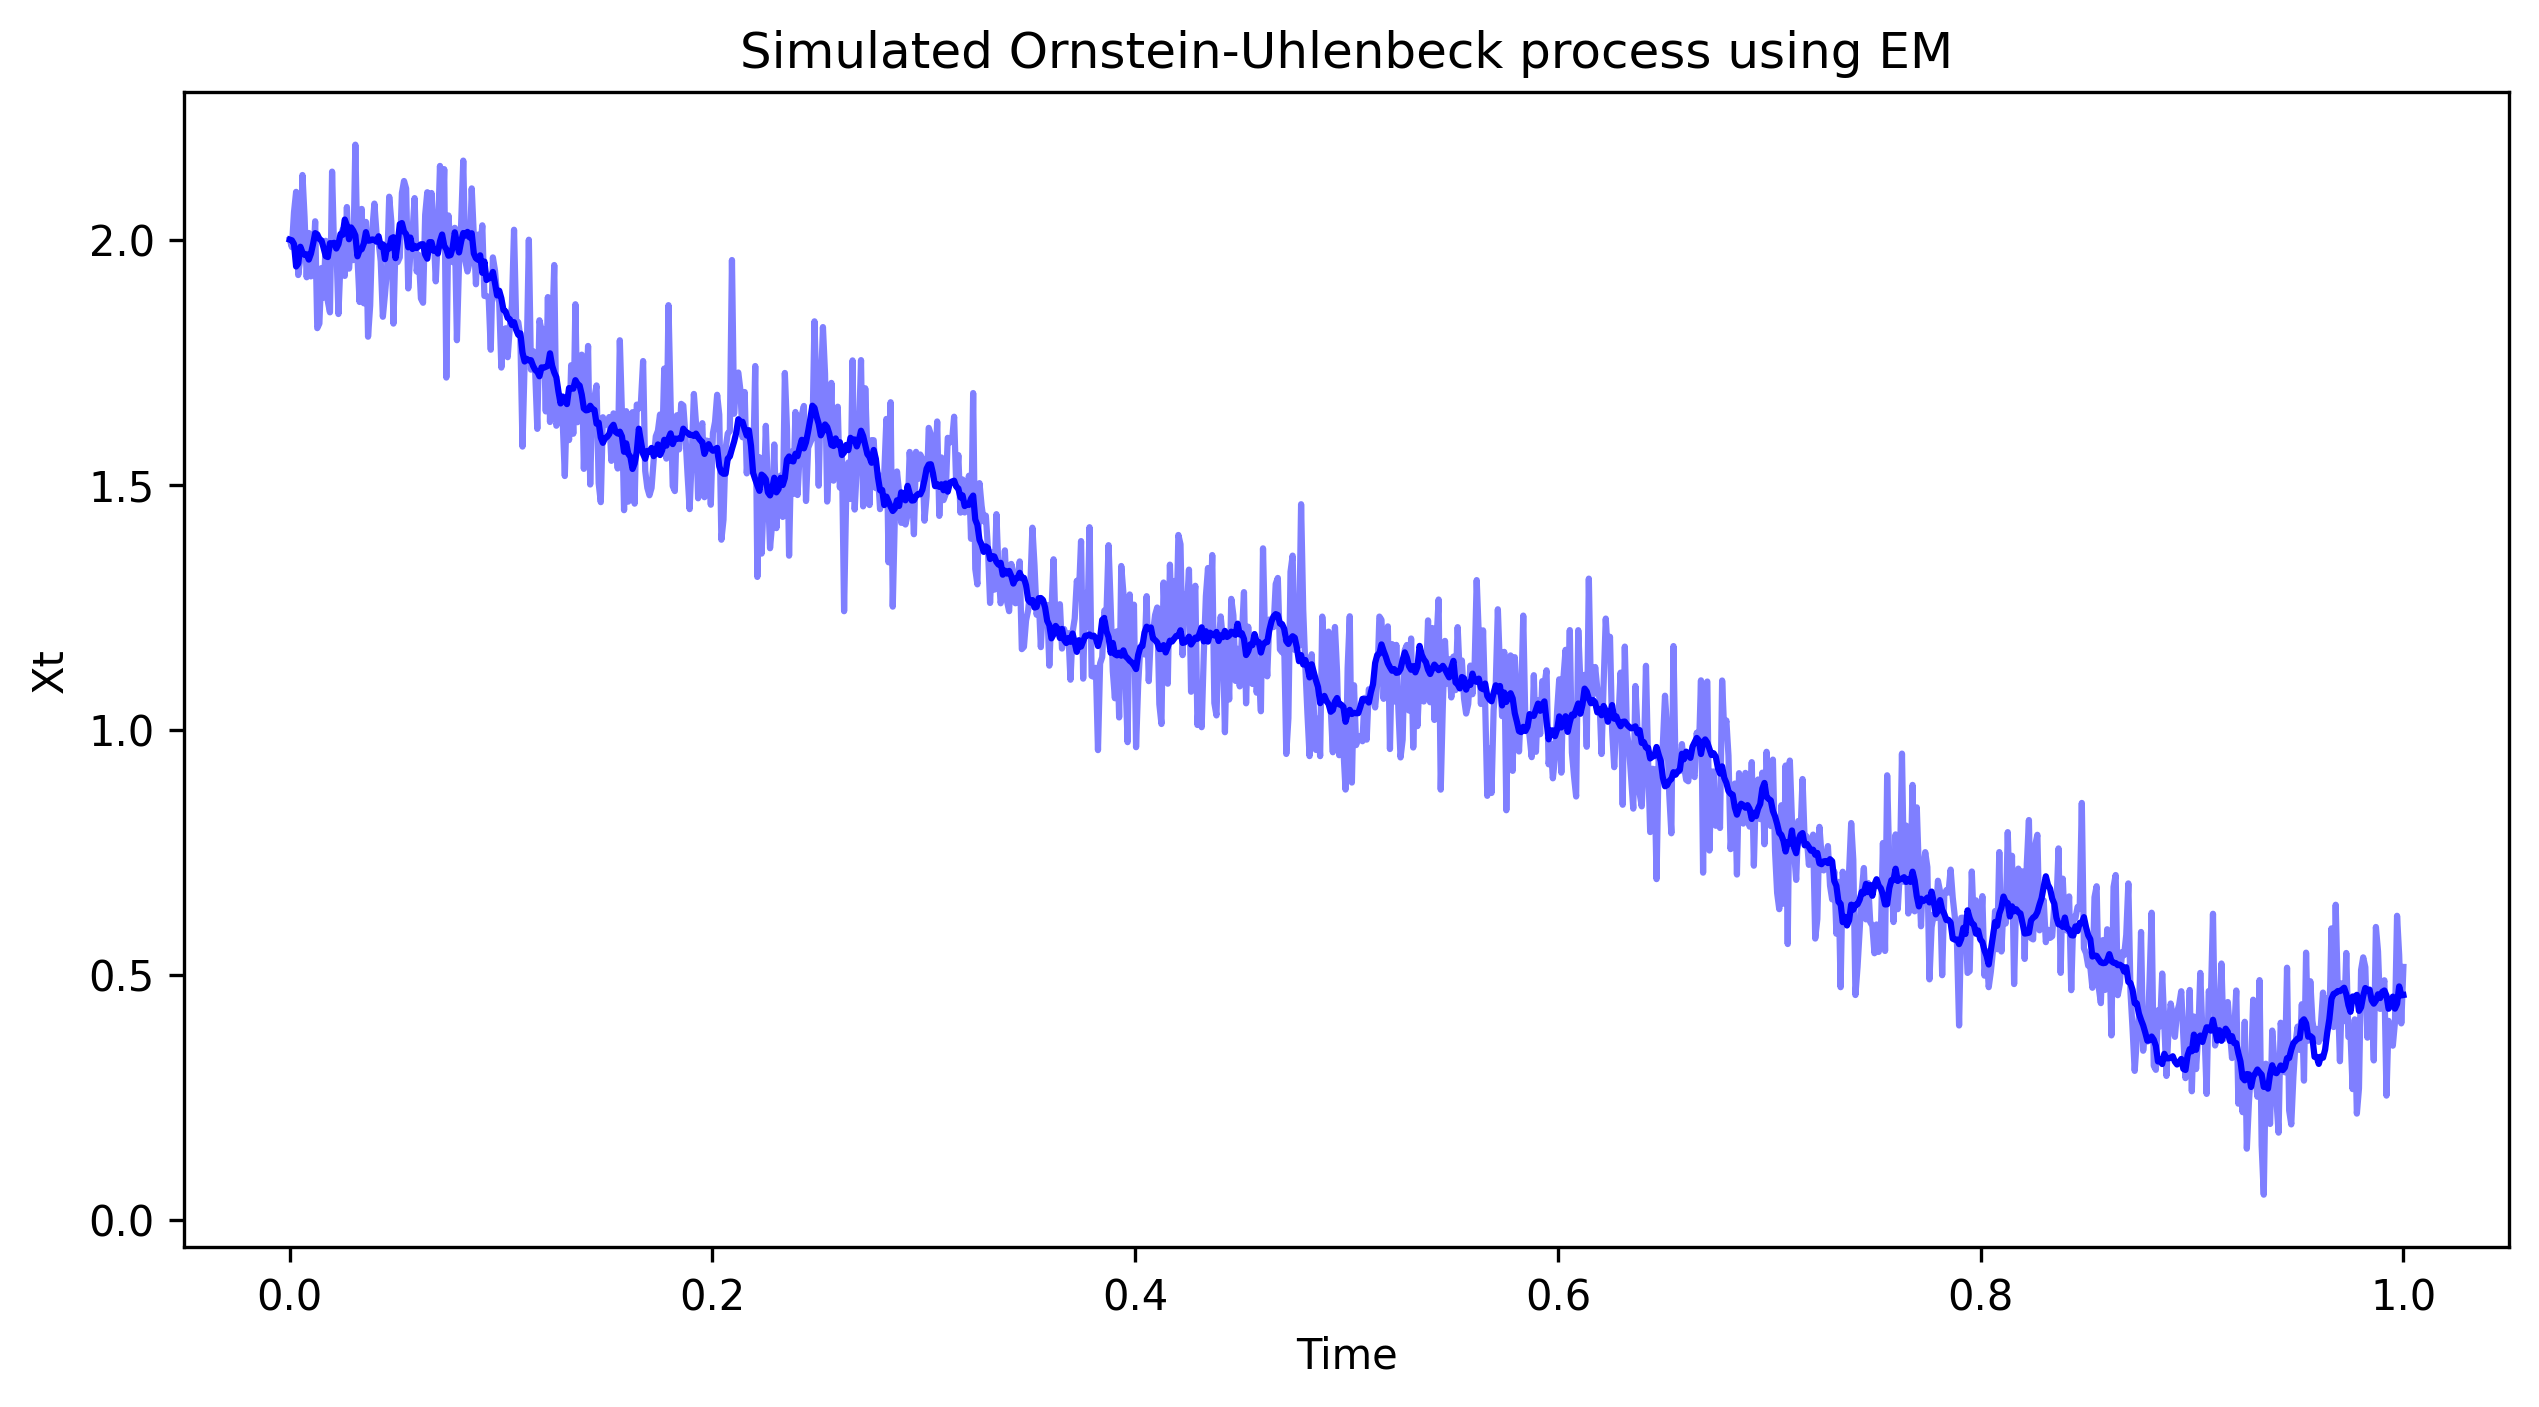

In [5]:
# add some gaussian noise on top of the model to simulate observations
np.random.seed(seed=42)
sigma_o = 0.1
eps = ss.norm.rvs(loc=0, scale=sigma_o, size=N)
eps[0] = 0
Xt = Zt + eps  # process + noise = measurement process

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(time, Xt, "-b", alpha=0.5)
plt.plot(time, Zt, "-b")
plt.title('Simulated Ornstein-Uhlenbeck process using EM')
plt.xlabel('Time')
plt.ylabel('Xt')
plt.show()

In [51]:
# estimate parameters by minimizing negative loglikelihood
def estimate_parameters(x0, Xt_partial, time_partial):

    mu, alpha, _, sigma_o = x0
    sigma = np.std(Xt_partial)

    x0 = [mu, alpha, sigma_o]
    
    result = minimize(
    loglikelihood,
    x0=x0,
    args=(Xt_partial, time_partial, sigma),
    method="L-BFGS-B",
    bounds=[[1e-15, 10], [1e-15, 40], [1e-7, 1]],
    tol=1e-12,
    )
    
    mu, alpha, sigma_o = result.x
        
    return mu, alpha, sigma_p, sigma_o

In [131]:
def estimate_parameters(x0, Xt_partial, time_partial):
    mu, alpha, sigma, sigma_0 = x0
    result = minimize(
        loglikelihood,
        x0=[mu, alpha, sigma],
        args=(Xt_partial, time_partial),
        method = "L-BFGS-B", 
        bounds = ((None, None), (0.05, None), (0.05, None)))

    mu, alpha, sigma = result.x
    
    return mu, alpha, sigma, sigma_0

In [52]:
def loglikelihood(c, Xt_partial, time_partial, sigma):
    _, L = kalman_filter(Xt_partial, time_partial, c[0], c[1], sigma, c[2])

    return -L

In [126]:
def loglikelihood(c, Xt_partial, time_parital):
    mu, alpha, sigma = c
    n = len(time_partial)
    dt = time[1] - time[0]

    L = -n/2 * np.log(sigma**2 / (2*alpha)) \
        -1/2 * np.sum(np.log(1-np.exp(-2*alpha*dt))) \
        -alpha/sigma**2 * np.sum((Xt_partial - mu - (Xt_partial - mu)*np.exp(-alpha * dt))**2/(1-np.exp(-2*alpha*dt)))
    
    return -L

In [117]:
# main Kalman filter implementation
def kalman_filter(Xt, time, mu, alpha, sigma, sigma_o, use_prev_state=False):   
    # assume time intervals are uniformal
    dt = time[1] - time[0]
    
    # calculate OU model parameters for Kalman filter
    A = mu * (1-np.exp(-alpha * dt))
    B = np.exp(-alpha * dt)
    F = np.array([[1,0],[A,B]])
    sigma_p = np.sqrt(sigma**2 / (2*alpha) * (1-np.exp(-2*alpha*dt)))

    P = np.eye(2) * sigma_p
    H = np.eye(2)
    Q = np.eye(2) * sigma_p
    R = np.eye(2) * sigma_o

    # vector for storing Kalman predictions
    Z = np.zeros([len(Xt),2])
    # vector for residuals
    Y = np.zeros([1,2])
    # vector for noisy, measured data
    Xt = np.column_stack((np.ones_like(Xt), Xt))

    # initialize Kalman predictions vector and -loglikelihood variable
    Z[0] = Xt[0]
    L = 0

    # Kalman filter - loop through time
    for i in range(len(time)-1):
        # prediction step
        # option to use true state here instead of previous prediction
        if use_prev_state:
            Z[i+1] = F @ Xt[i]
        else:
            Z[i+1] = F @ Z[i]
        P = F @ P @ F.T + Q

        # update step
        Y = Xt[i+1] - H @ Z[i+1] # measurement pre-fit residual
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S) # Kalman gain
        if use_prev_state:
            Z[i+1] = Xt[i] + K @ Y
        else:
            Z[i+1] = Z[i] + K @ Y
        P = (np.eye(2) - K @ H) @ P

        # compute marginal negative loglikelihood
        L += -1/2 * (Y.T @ np.linalg.inv(S) @ Y + np.log(np.linalg.det(S)) + 2 * np.log(2*np.pi))
        # L += -1/np.abs(Y[1])  
    return Z, L

In [31]:
np.std(np.column_stack((np.ones_like(Xt), Xt)), axis=0)[1]

0.4983848310435547

In [136]:
def kalman_filter_with_fitting(Xt, time, mu, alpha, sigma, sigma_o, use_prev_state=False):    
    time = time[0:300]
    Xt = Xt[0:300]
 
    # assume time intervals are uniformal
    dt = time[1] - time[0]



    # calculate OU model parameters for Kalman filter
    A = mu * (1-np.exp(-alpha * dt))
    B = np.exp(-alpha * dt)
    F = np.array([[1,0],[A,B]])
    sigma_p = np.sqrt(sigma**2 / (2*alpha) * (1-np.exp(-2*alpha*dt)))
    
    P = np.eye(2) * sigma_p
    H = np.eye(2)
    Q = np.eye(2) * sigma_p
    R = np.eye(2) * sigma_o

    # vector for storing Kalman predictions
    Z = np.zeros([len(Xt),2])
    # vector for residuals
    Y = np.zeros([1,2])
    # vector for noisy, measured data
    Xt = np.column_stack((np.ones_like(Xt), Xt))

    # initialize Kalman predictions vector
    Z[0] = Xt[0]

    # Kalman filter - loop through time
    for i in range(len(time)-1):
        # prediction step
        # option to use true state here instead of previous prediction
        if use_prev_state:
            Z[i+1] = F @ Xt[i]
        else:
            Z[i+1] = F @ Z[i]
        P = F @ P @ F.T + Q

        # update step
        Y = Xt[i+1] - H @ Z[i+1] # measurement pre-fit residual
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S) # Kalman gain
        if use_prev_state:
            Z[i+1] = Xt[i] + K @ Y
        else:
            Z[i+1] = Z[i] + K @ Y
        P = (np.eye(2) - K @ H) @ P
        
        Xt_partial = Xt[0:i,1]
        time_partial = time[0:i]

        print(len(time_partial))

        if len(time_partial) > 10:
            mu, alpha, sigma, sigma_o = estimate_parameters([mu, alpha, sigma, sigma_o], Xt_partial, time_partial)
            
            P0 = np.eye(2) * sigma_p
            H = np.eye(2)
            Q = np.eye(2) * sigma_p
            R = np.eye(2) * sigma_o
            A = mu * (1-np.exp(-alpha * dt))
            B = np.exp(-alpha * dt)
            F = np.array([[1,0],[A,B]])
            sigma_p = np.sqrt(sigma**2 / (2*alpha) * (1-np.exp(-2*alpha*dt)))

            print("-->\t", mu, alpha, sigma_p, sigma_o)
    return Z

In [30]:
sigma_p

0.01578770083807952

[0.5, 3, 0.5, 0.1]
2.0142083365261745 16.169381900570496 0.05 0.1


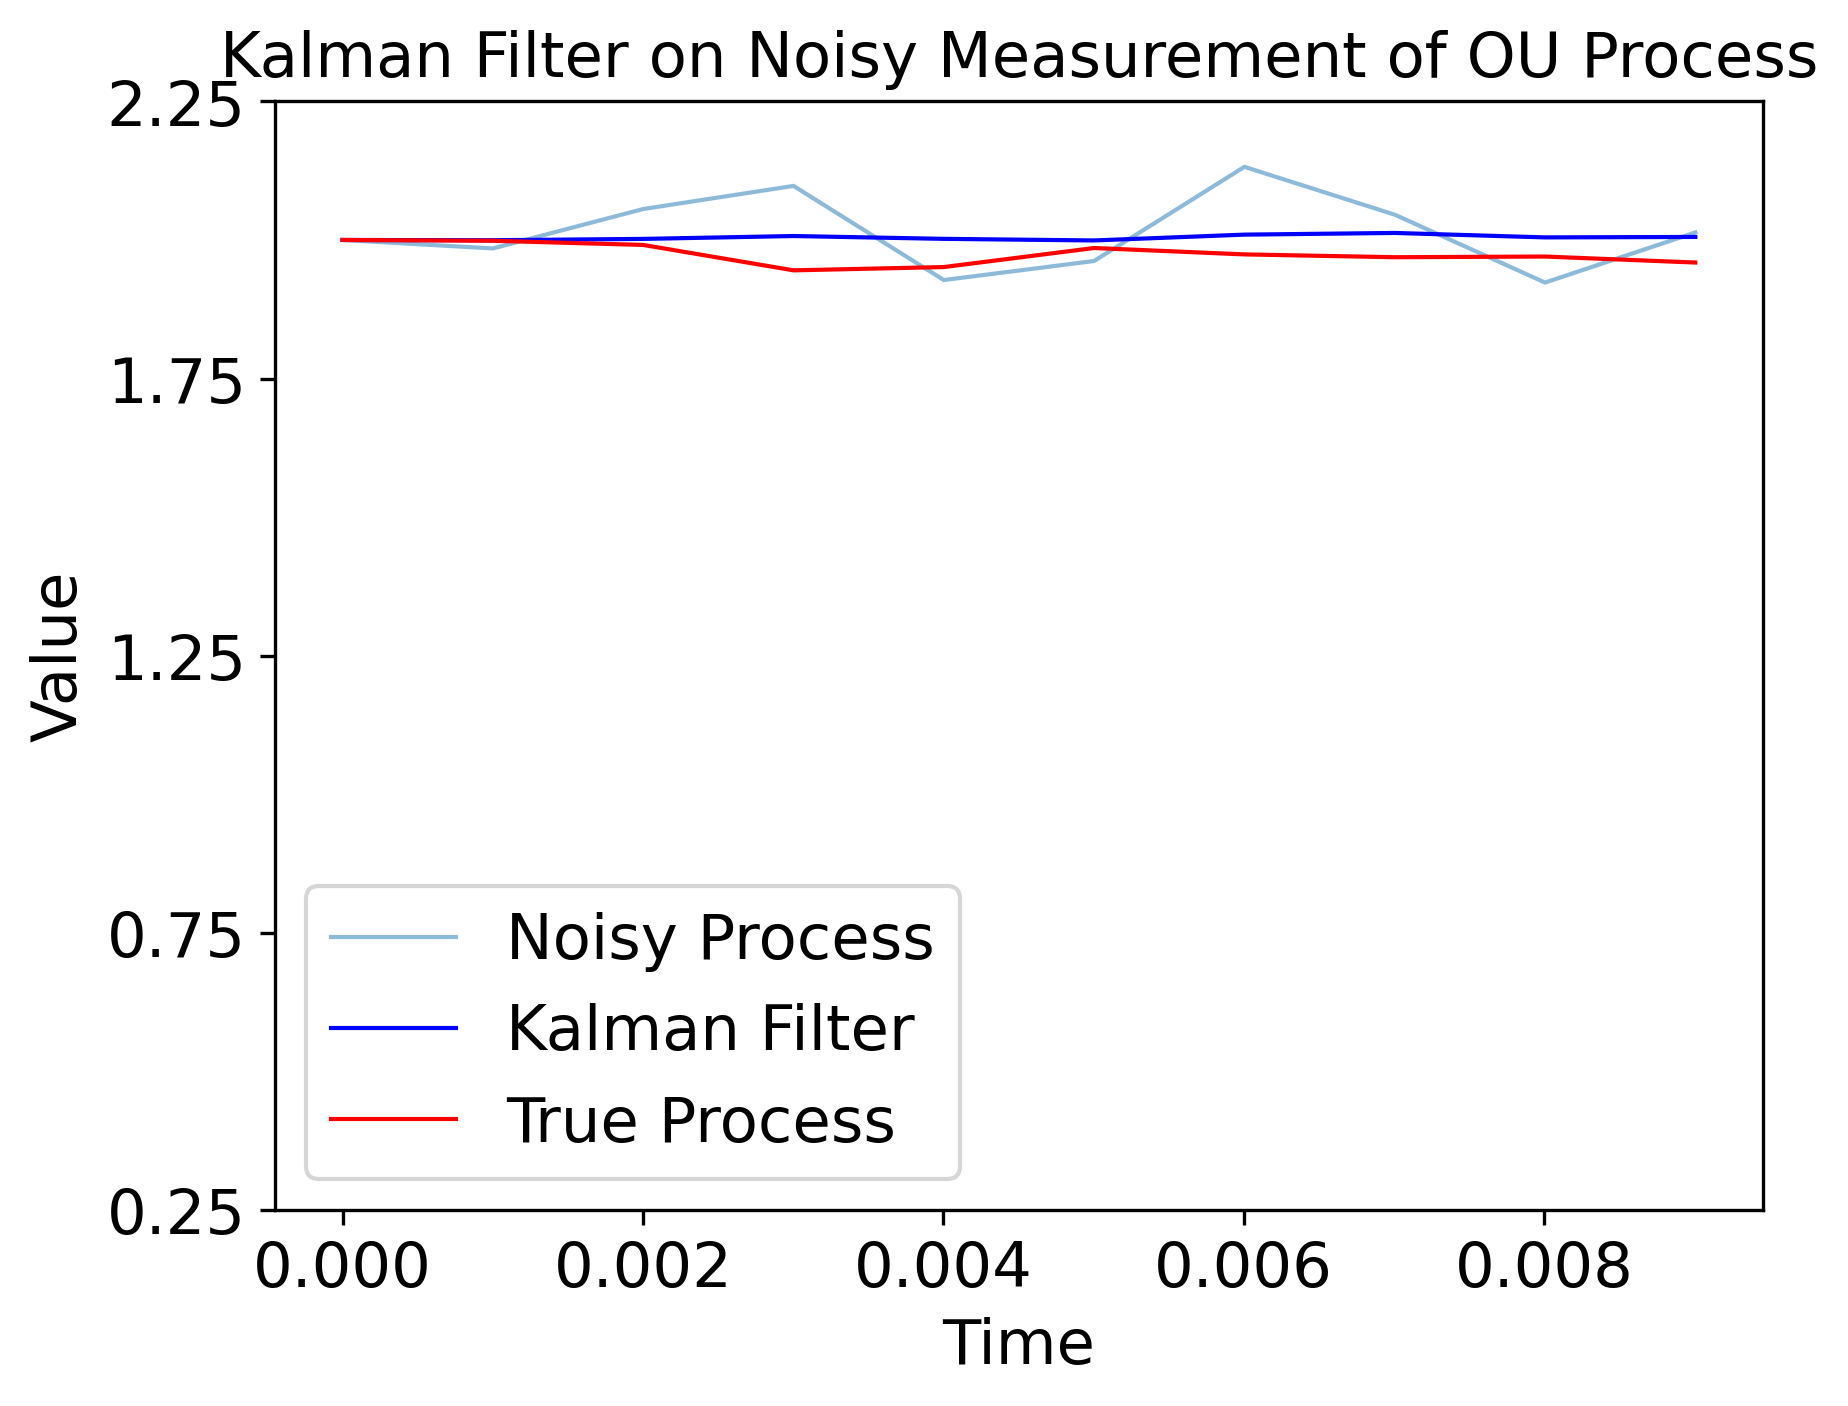

In [132]:
sigma_p = 0.015787

x0 = [0.5, 3, 0.5, 0.1]


Xt_partial = Xt[0:10]
time_partial = time[0:10]

sigma = np.std(Xt_partial)

print(x0)

mu, alpha, sigma, sigma_o = estimate_parameters(x0, Xt_partial, time_partial)
print(mu, alpha, sigma, sigma_o)
# mu, alpha, sigma_o = 0.5, 3, 0.1
# alpha = 3
# mu, alpha, sigma, sigma_o = [60000, 0.05, 10000000, 0.1]
Z, L = kalman_filter(Xt_partial, time_partial, mu, alpha, sigma, sigma_o)

plt.figure(dpi=300)
plt.title("Kalman Filter on Noisy Measurement of OU Process", size=15)
plt.plot(time_partial, Xt_partial, linewidth=1, label="Noisy Process", alpha=0.5)
plt.plot(time_partial, Z[:,1], linewidth=1, label="Kalman Filter", color="blue") # changed here to reduce to 300
plt.plot(time_partial, Zt[0:len(time_partial)], linewidth=1, label="True Process", color="red")
plt.xlabel("Time", size=15)
plt.ylabel("Value", size=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(np.linspace(0.25,2.25,5),fontsize=15)
plt.savefig("kalman-on-OU.png",bbox_inches='tight')
plt.show()

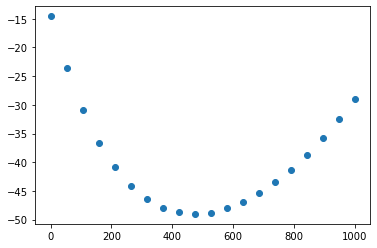

In [76]:
L_list = []
rangee = np.linspace(0.001,1000,20)
for i in rangee:
    x0 = [0.5, i, sigma_p, sigma_o]
    L_list.append(loglikelihood(x0, Xt_partial, time_partial))
    
plt.scatter(rangee, L_list)
# plt.axvline(B)

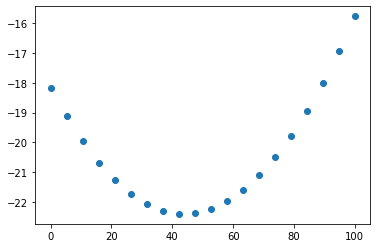

In [73]:
L_list = []
rangee = np.linspace(0.001,100,20)
for i in rangee:
    x0 = [0.5, i, sigma_p, sigma_o]
    L_list.append(loglikelihood(x0, Xt_partial, time_partial))
    
plt.scatter(rangee, L_list)
# plt.axvline(B)

In [93]:
alpha = 3
sigma_p = np.sqrt(sigma**2 / (2*alpha) * (1-np.exp(-2*alpha*dt)))


Z, L = kalman_filter(Xt, time, mu, alpha, sigma, sigma_o, False)
# Z = kalman_filter_with_fitting(Yt, time, A, B, P0, H, Q, R)
print(sigma_o)

0.5 3 0.015795576920453084 0.1
0.1


In [137]:
Z = kalman_filter_with_fitting(Xt, time, mu, alpha, sigma, sigma_o)

0
1
2
3
4
5
6
7
8
9
10
11
-->	 2.006096825577708 14.95973144747851 0.0015701590967035252 0.1
12
-->	 2.0009408050682365 14.46347296418183 0.0015705472226865485 0.1
13
-->	 2.0037495986302964 14.300806061643707 0.001570674480133675 0.1
14
-->	 1.9905754771860777 11.397110911941141 0.0015729490017410868 0.1
15
-->	 1.9797891803358378 10.06501389571396 0.0015739943029789965 0.1
16
-->	 1.977430329770419 10.005009044526025 0.0015740414163233503 0.1
17
-->	 1.9717937871030133 9.64107941335412 0.0015743272094166155 0.1
18
-->	 1.973228239044041 9.616106105799823 0.0015743468240761616 0.1
19
-->	 1.9679883616310143 9.265012390907552 0.001574622625079373 0.1
20
-->	 1.962169238034003 8.840919567733225 0.0015749558780568996 0.1
21
-->	 1.9705779864681567 8.048787786293808 0.0015755786524308758 0.1
22
-->	 1.9705982696661515 8.048787781313282 0.0015755786524347952 0.1
23
-->	 1.9713814615363787 8.041524711698017 0.0015755843645665214 0.1
24
-->	 1.9662486832678279 7.724986143329463 0.00157583334

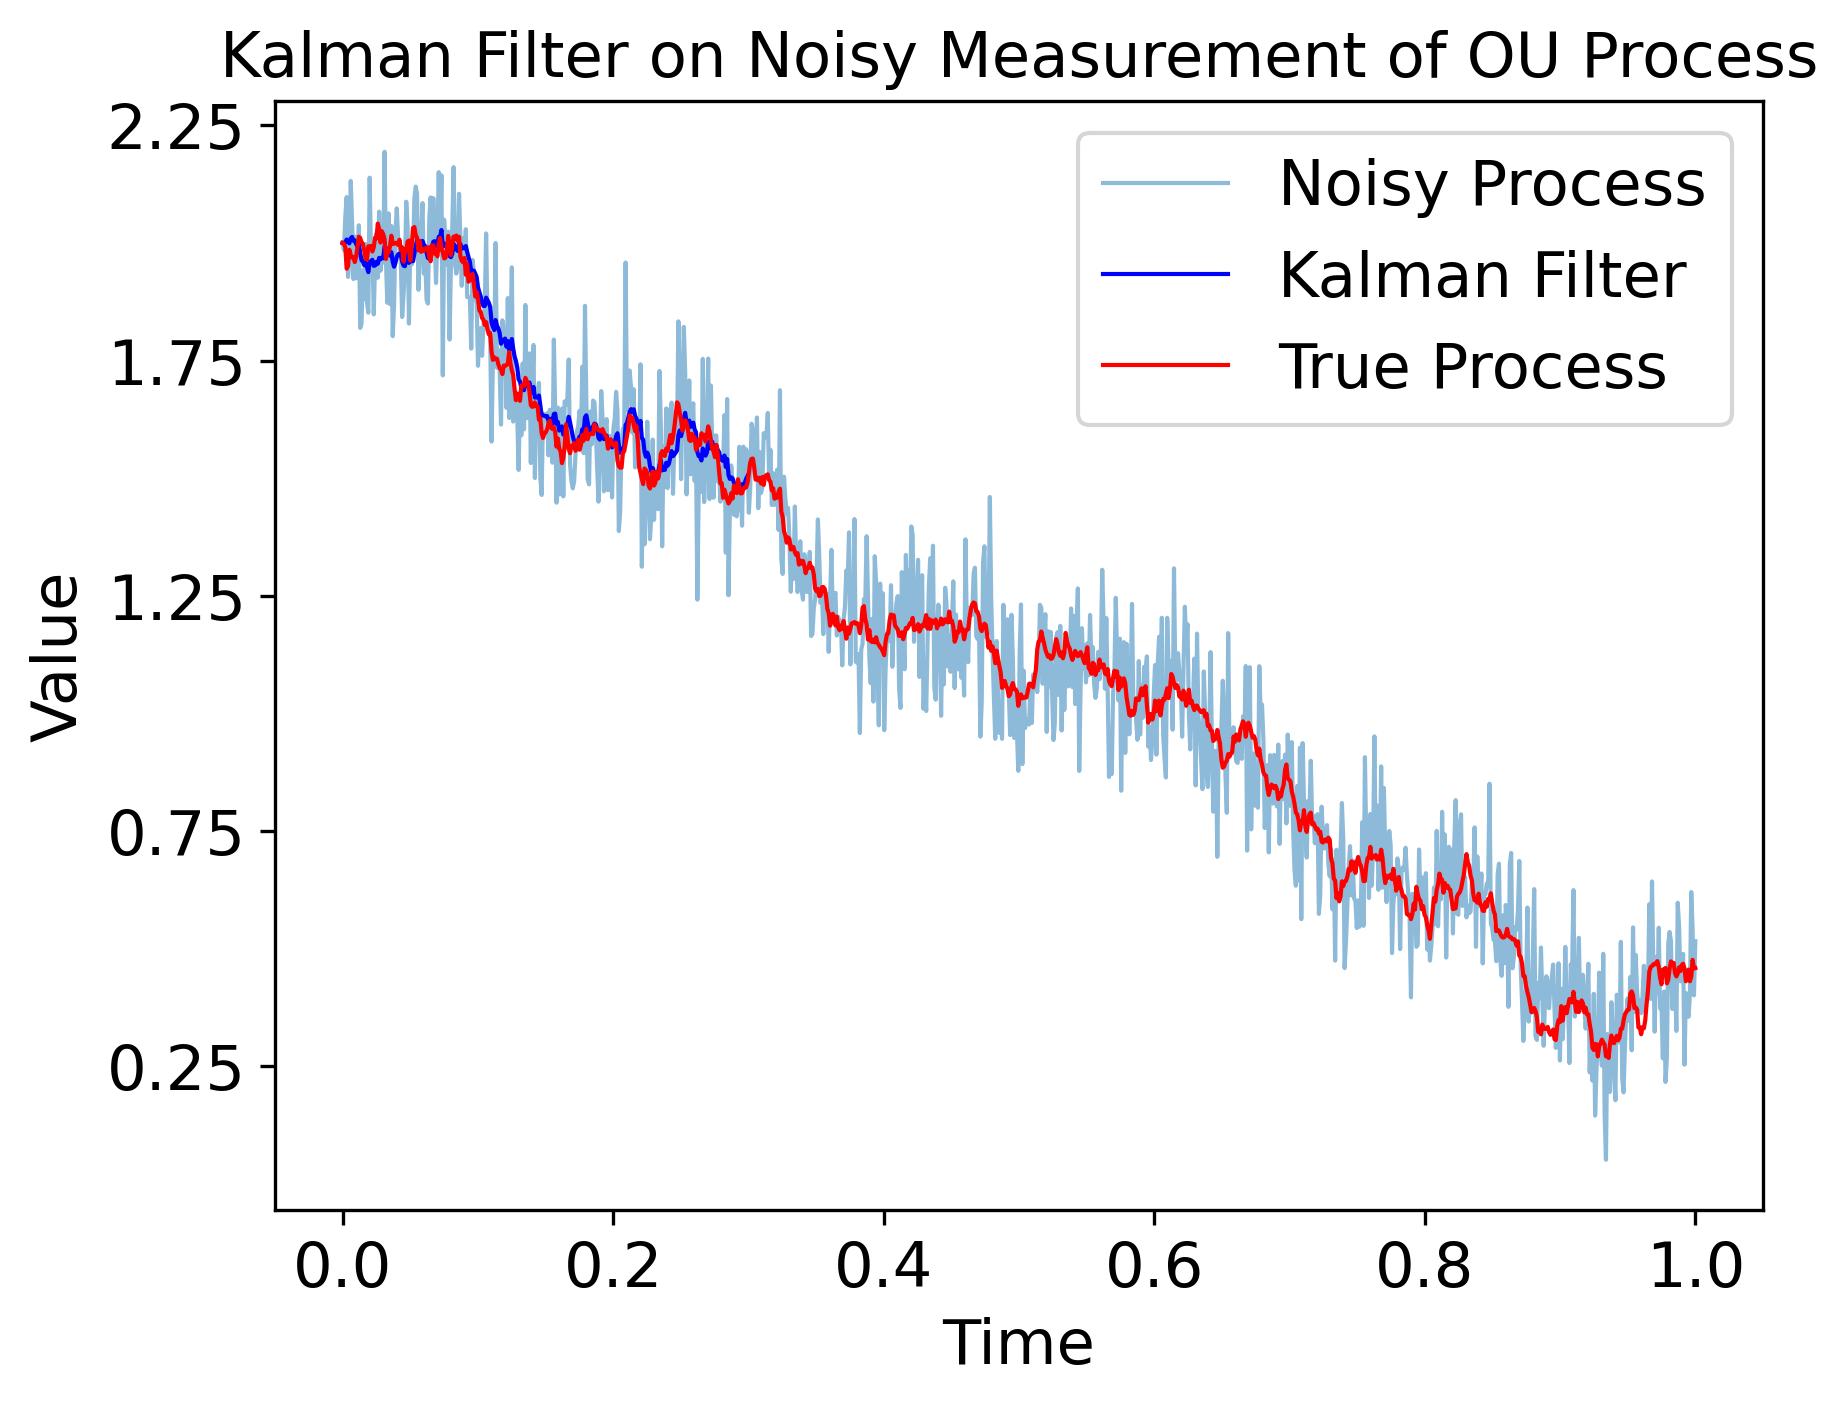

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

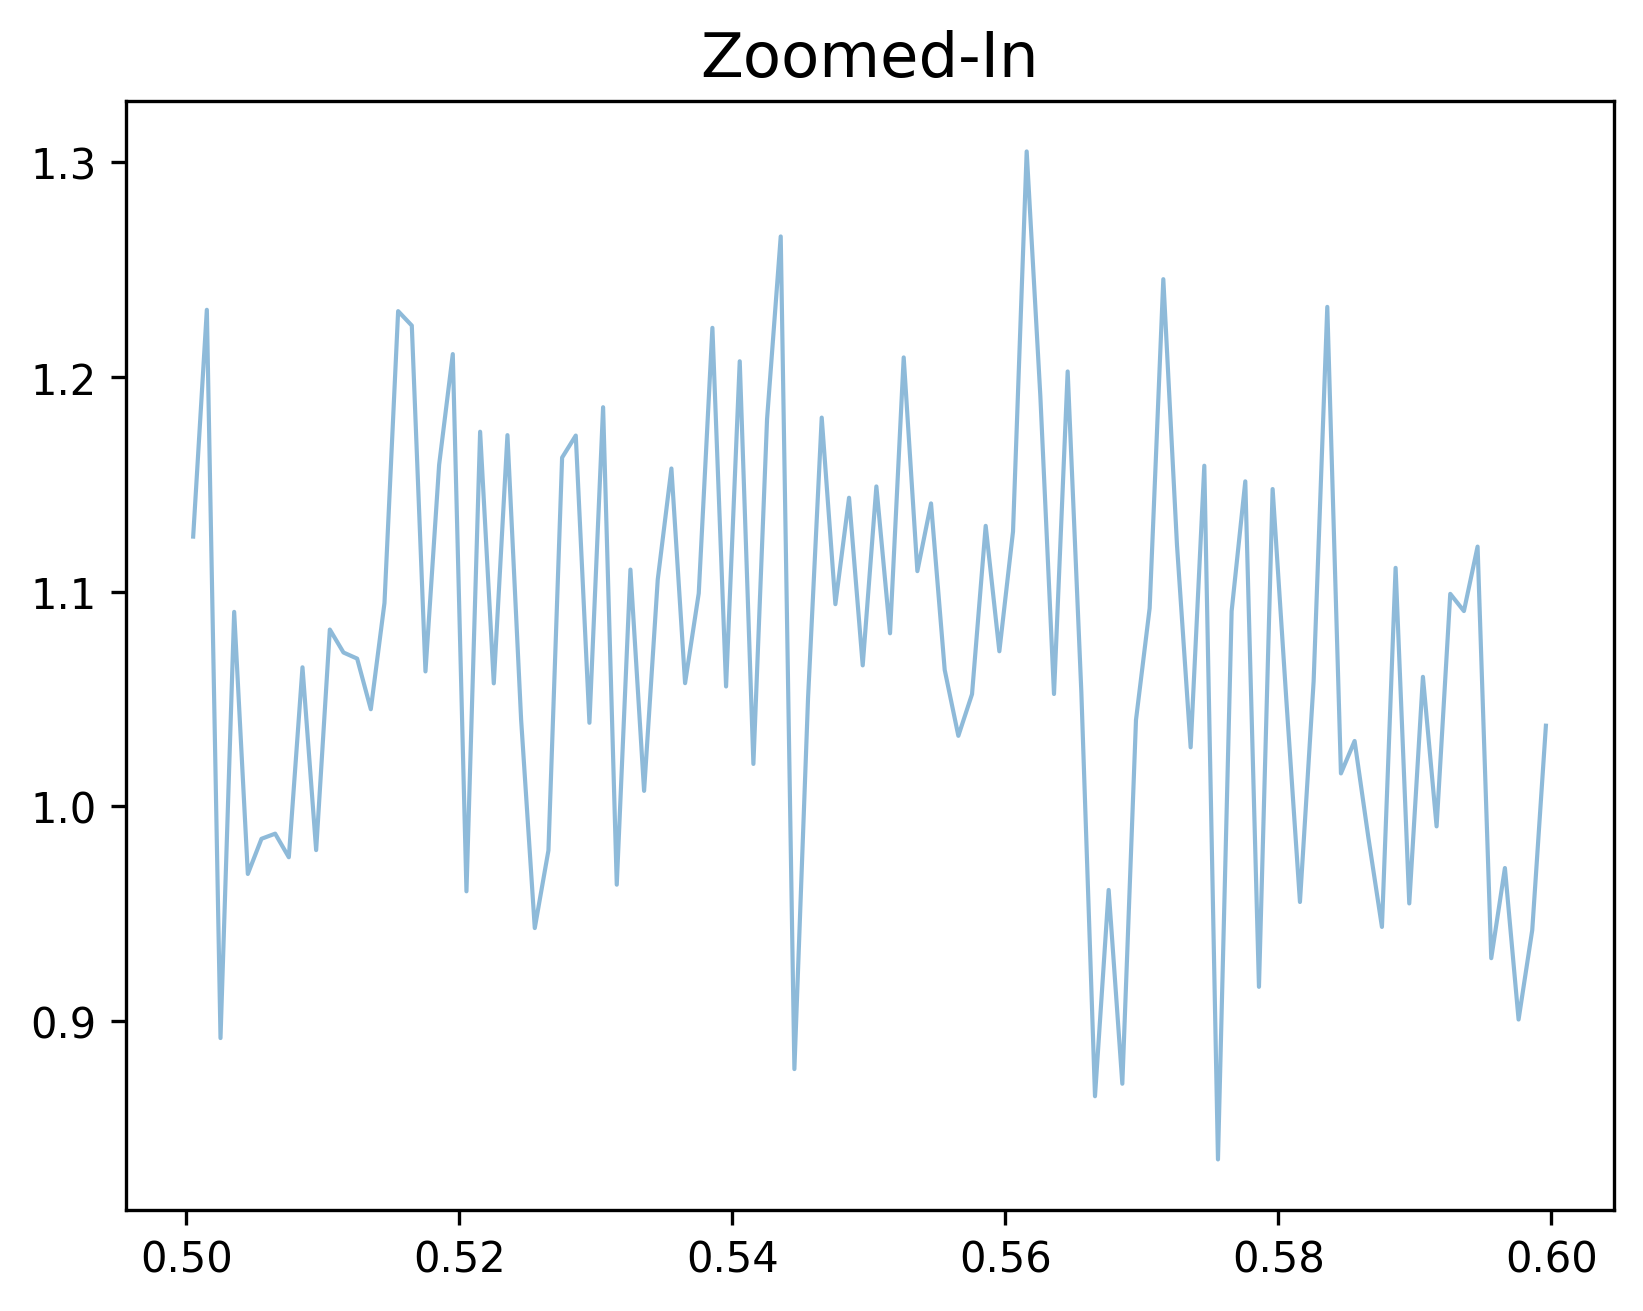

In [139]:
plt.figure(dpi=300)
plt.title("Kalman Filter on Noisy Measurement of OU Process", size=15)
plt.plot(time, Xt, linewidth=1, label="Noisy Process", alpha=0.5)
plt.plot(time[0:300], Z[:,1], linewidth=1, label="Kalman Filter", color="blue") # changed here to reduce to 300
plt.plot(time, Zt, linewidth=1, label="True Process", color="red")
plt.xlabel("Time", size=15)
plt.ylabel("Value", size=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(np.linspace(0.25,2.25,5),fontsize=15)
plt.savefig("kalman-on-OU.png",bbox_inches='tight')
plt.show()


plt.figure(dpi=300)
plt.title("Zoomed-In", size=15)
plt.plot(time[500:600], Xt[500:600], linewidth=1, label="Noisy Process", alpha=0.5)
plt.plot(time[500:600], Z[:,1][500:600], linewidth=1, label="Kalman Filter", color="blue")
plt.plot(time[500:600], Zt[500:600], linewidth=1, label="True Process", color="red")
plt.xlabel("Time", size=15)
plt.ylabel("Value", size=15)
# plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(np.linspace(0.6,1.4,6),fontsize=15)
plt.savefig("kalman-on-OU-zoom.png",bbox_inches='tight')
plt.show()

In [255]:
import yfinance as yf

# load in QQQ data and retrieve open and close prices
qqq = yf.Ticker("AAPL")
data = qqq.history(period="1y")

open_prices = data['Open'].dropna()
close_prices = data['Close'].dropna()

open_returns = open_prices.pct_change().dropna().values
# open_returns

# calculate mean and std using first 30 days of data
start_index = 30

start_data = open_prices[0:start_index]
# start_data = open_returns[0:start_index]
# mu = np.mean(start_data)
# sigma = np.std(start_data)

sigma_o = 5

dt = 1

mu, alpha, sigma, sigma_o = estimate_parameters([0.5, 3, 0.1, sigma_o], start_data, np.arange(0,len(start_data),1))

print(mu, alpha, sigma, sigma_o)

# the two parameters we can change, will be calculated recursively later
# alpha = 0.05


sigma_p = np.sqrt(sigma**2 / (2*alpha) * (1-np.exp(-2*alpha*dt))) * 100
A = mu * (1-np.exp(-alpha * dt))
B = np.exp(-alpha * dt)
P0 = np.eye(2) * sigma_p
H = np.eye(2)
Q = np.eye(2) * sigma_p
R = np.eye(2) * sigma_o

Yt = open_prices[start_index:].values[1:]
# Yt = open_returns[start_index:]#.values
time = np.arange(0,len(Yt),dt)

# mu, alpha, sigma, sigma_o = [0.1, 0.1, 0.1, 1000]

Z = kalman_filter_with_fitting(Yt, time, mu, alpha, sigma, sigma_o, False)

170.2369676629957 0.05 0.3523897564516039 5
0
1
2
3
4
5
6
7
8
9
10
11
-->	 181.37284392048326 0.05 0.12782439579475768 5
12
-->	 181.6061622792776 0.05 0.13434391838304338 5
13
-->	 181.7147112556754 0.05 0.13596142969920463 5
14
-->	 181.93652497339016 0.05 0.1435807703721644 5
15
-->	 182.213763776769 0.05 0.1563798270884642 5
16
-->	 182.39782809704417 0.05 0.16244597807165356 5
17
-->	 182.67976514495015 0.05 0.17757069531009634 5
18
-->	 182.99401367477077 0.05 0.19677139950607564 5
19
-->	 183.40886755949091 0.05 0.22960633382384024 5
20
-->	 183.8893119110237 0.05 0.2712610718709265 5
21
-->	 184.2191767452575 0.05 0.2906075688579889 5
22
-->	 184.4407269413042 0.05 0.2997442504922444 5
23
-->	 184.7110038059501 0.05 0.3140678935710808 5
24
-->	 184.86952631436338 0.05 0.3192773122714713 5
25
-->	 185.01138172905348 0.05 0.32374341348158275 5
26
-->	 185.16224861273494 0.05 0.3291335035766311 5
27
-->	 185.3321887005108 0.05 0.3363792479878145 5
28
-->	 185.48038692600696 0.05 0

/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3109708407.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  open_prices[start_index] + open_prices[start_index] *np.cumsum(open_returns[start_index:]),
/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3109708407.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  open_prices[start_index] + open_prices[start_index] *np.cumsum(Z[:, 1]),
/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3109708407.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

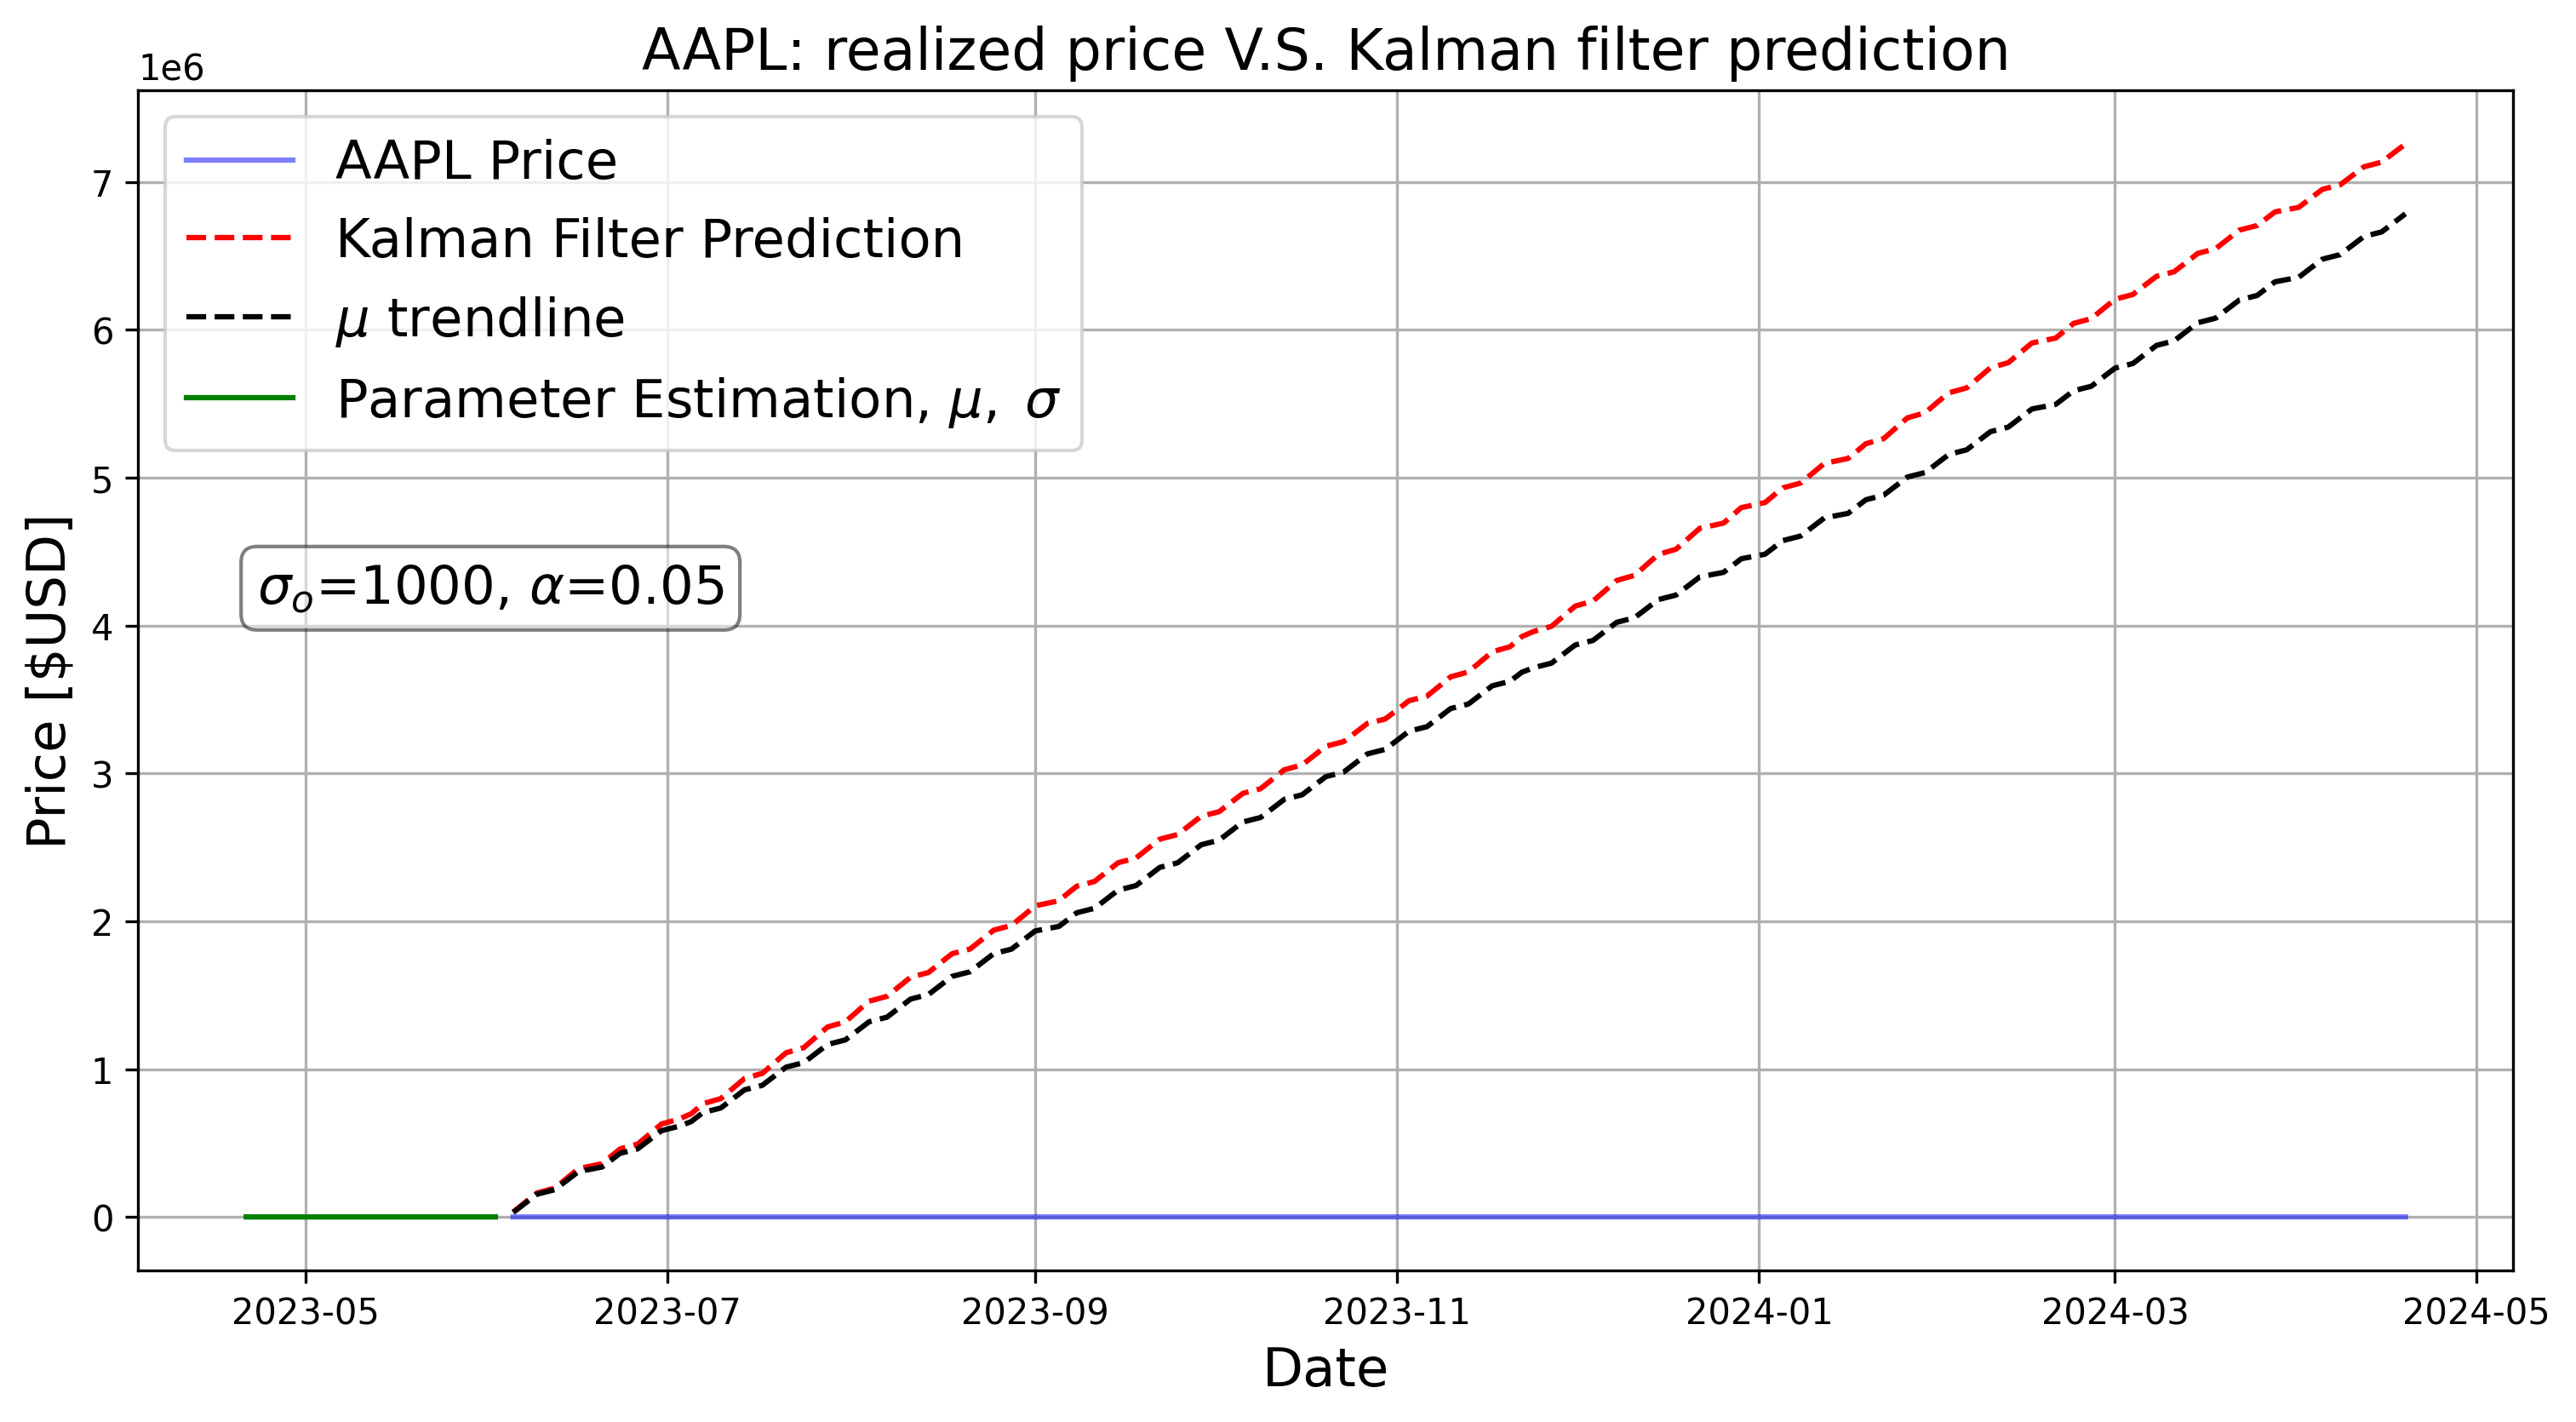

In [241]:
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(np.array(data.index[start_index+1:]), 
         open_prices[start_index] + open_prices[start_index] *np.cumsum(open_returns[start_index:]), 
         label='AAPL Price', color='blue', alpha=0.5)
# plt.plot(np.array(data.index[start_index+1:]), 
#          np.array(open_prices[start_index+1:]), 
#          label='asdfasdf', color='red', alpha=0.5)
plt.plot(np.array(data.index[start_index+1:]), 
         open_prices[start_index] + open_prices[start_index] *np.cumsum(Z[:, 1]), 
         "--",label='Kalman Filter Prediction', color='red')
plt.plot(np.array(data.index[start_index+1:]), 
         open_prices[start_index] + mu*open_prices[start_index]*np.cumsum(np.ones(len(Z[:,1]))), 
         "--",label=r'$\mu$ trendline', color='black')
plt.plot(np.array(data.index[1:start_index+1]), 
         open_prices[0] + open_prices[0] *np.cumsum(open_returns[0:start_index]),
         label=r'Parameter Estimation, $\mu, \; \sigma$', color='green')
plt.title('AAPL: realized price V.S. Kalman filter prediction', size=16)
plt.text(0.05, 0.6, r'$\sigma_o$='+str(sigma_o)+r', $\alpha$='+str(alpha), transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# plt.text(0.05, 0.95, r'$\sigma_o$='+str(sigma_o)+r', $\alpha$='+str(alpha), transform=plt.gca().transAxes, fontsize=15,
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.xlabel('Date', size=15)
plt.ylabel('Price [$USD]', size=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig("AAPL-price-with-kalman-increasing-sigmao.png", bbox_inches='tight')
plt.show()

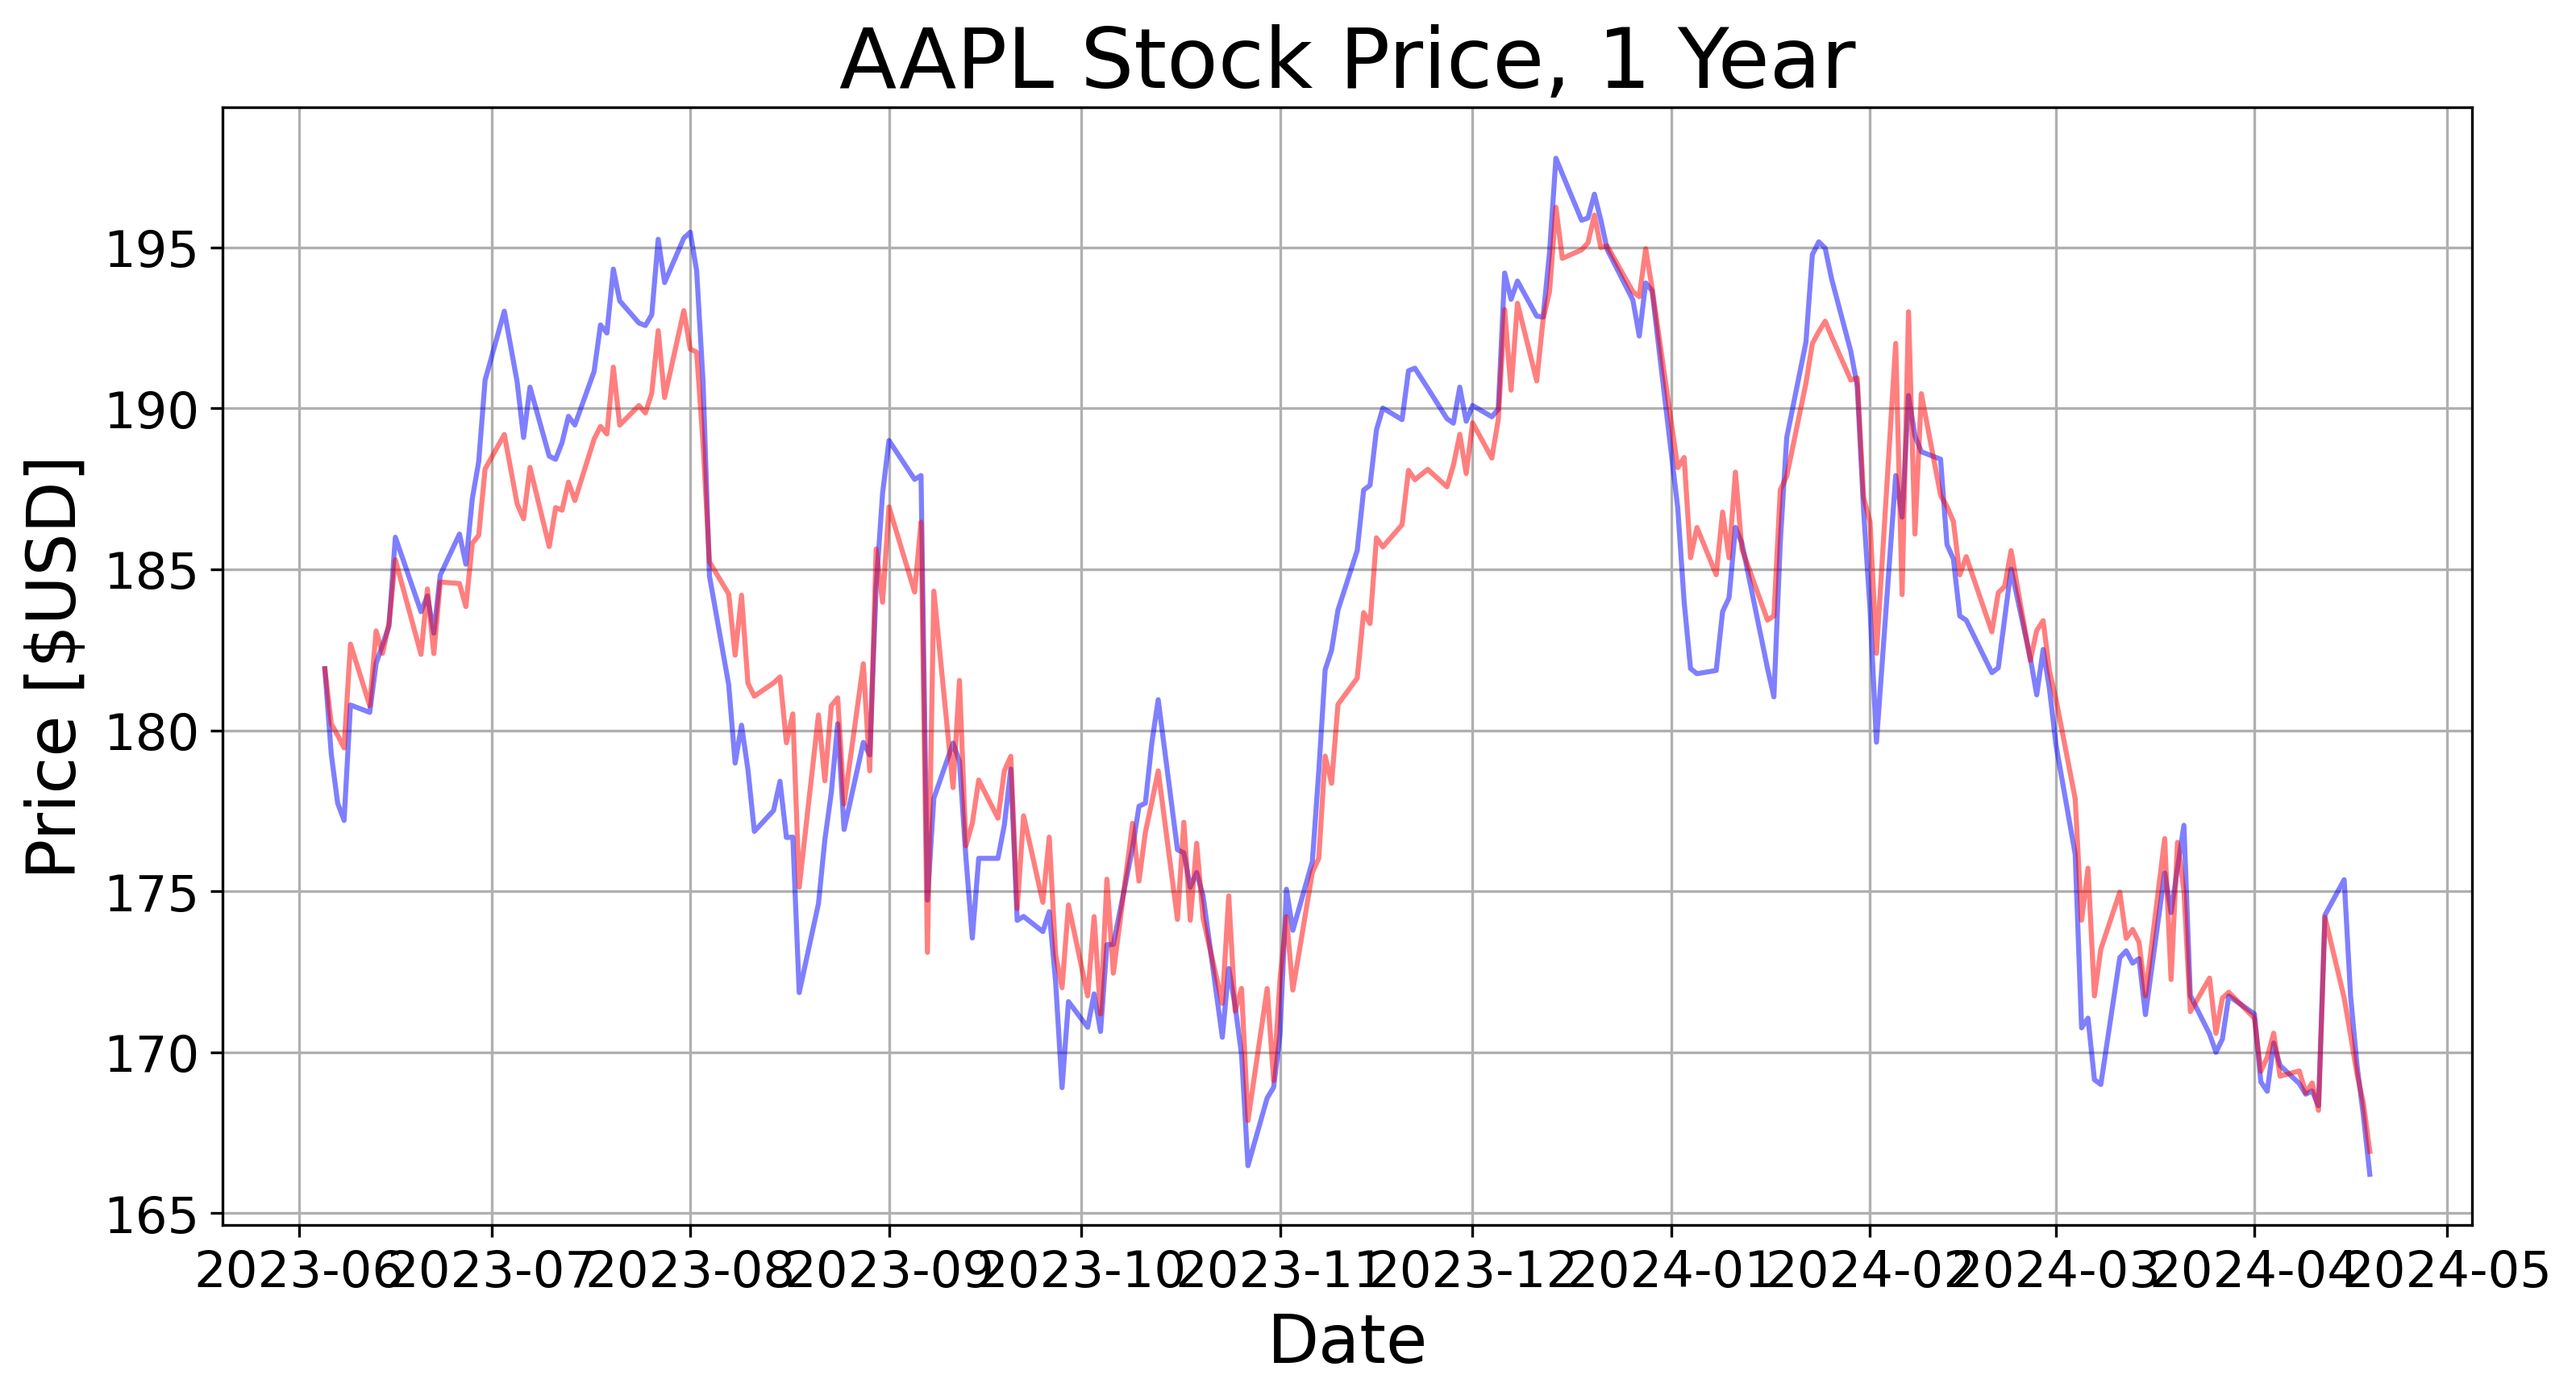

In [256]:
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(np.array(data.index[start_index+1:]), 
         open_prices[start_index+1:],
         label='Parameter Estimation', color='blue', alpha=0.5)
plt.plot(np.array(data.index[start_index+1:]), 
         Z[:,1],
         label='Parameter Estimation', color='red', alpha=0.5)
plt.title('AAPL Stock Price, 1 Year', size=25)
plt.xlabel('Date', size=20)
plt.ylabel('Price [$USD]', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(fontsize=15)
plt.grid(True)
plt.savefig("AAPL-price.png", bbox_inches='tight')
plt.show()

/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/1655066174.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  open_prices[0] + open_prices[0] *np.cumsum(open_returns),


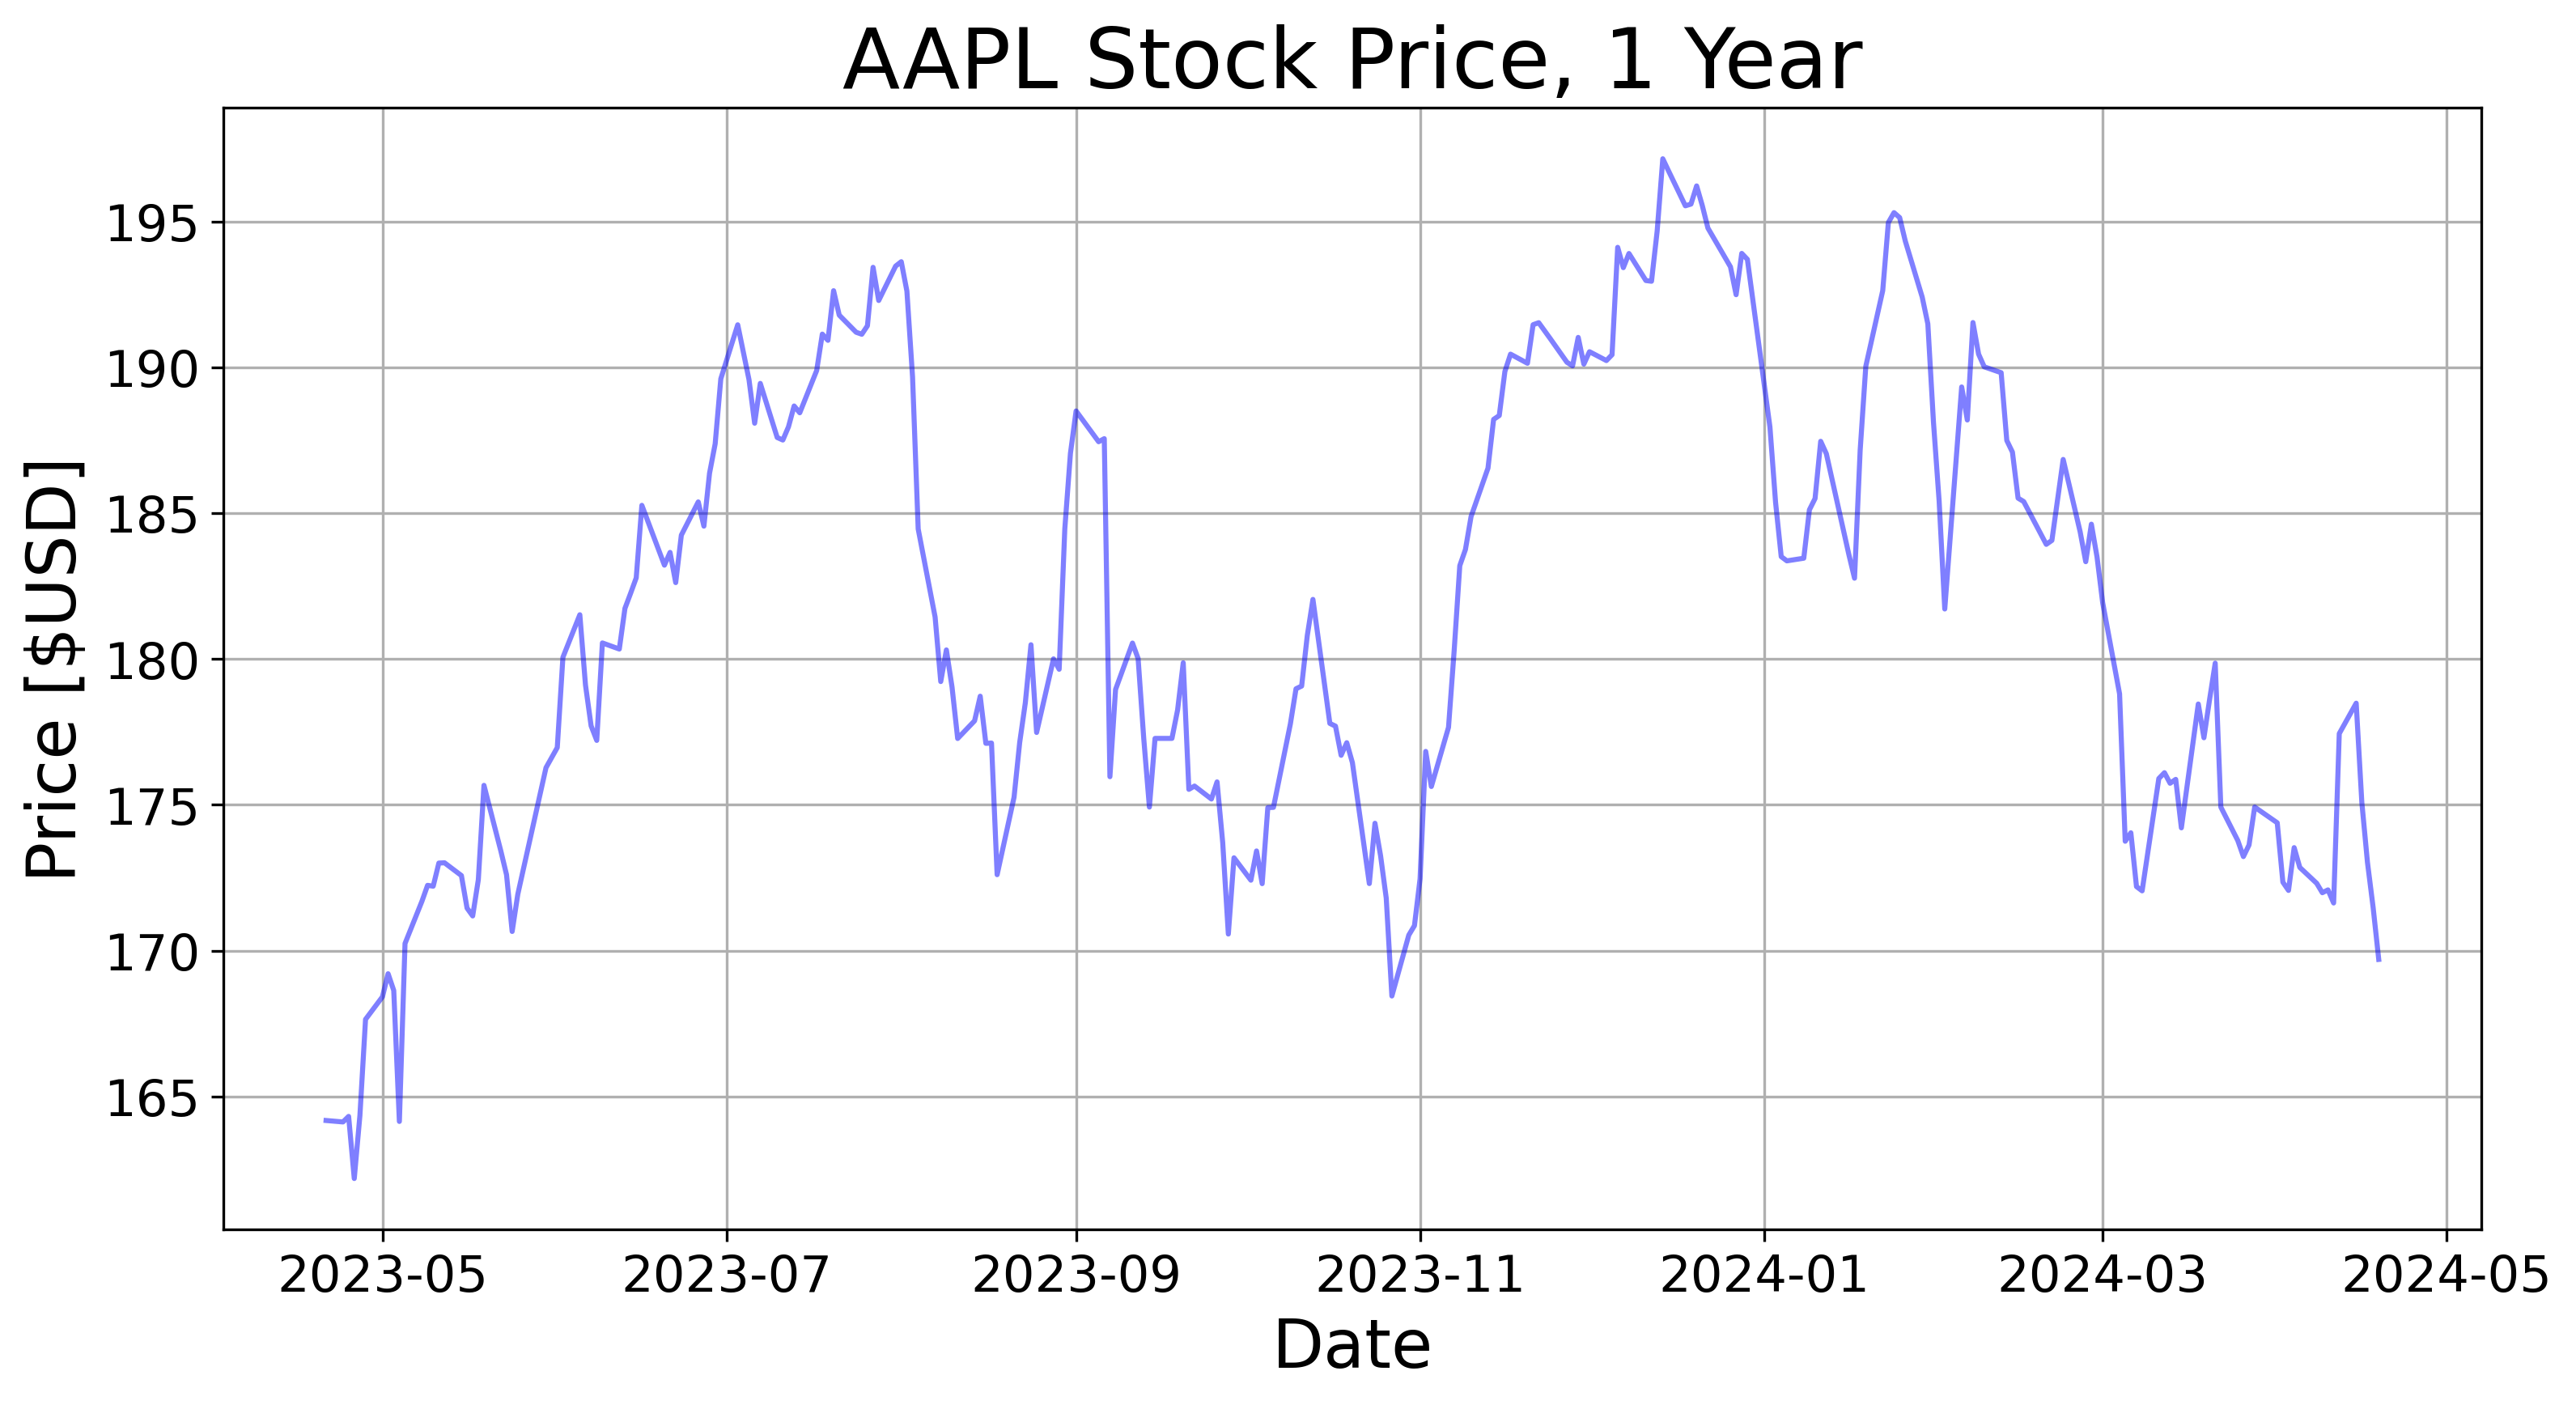

In [222]:
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(np.array(data.index[1:]), 
         open_prices[0] + open_prices[0] *np.cumsum(open_returns),
         label='Parameter Estimation', color='blue', alpha=0.5)
plt.title('AAPL Stock Price, 1 Year', size=25)
plt.xlabel('Date', size=20)
plt.ylabel('Price [$USD]', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(fontsize=15)
plt.grid(True)
plt.savefig("AAPL-price.png", bbox_inches='tight')
plt.show()

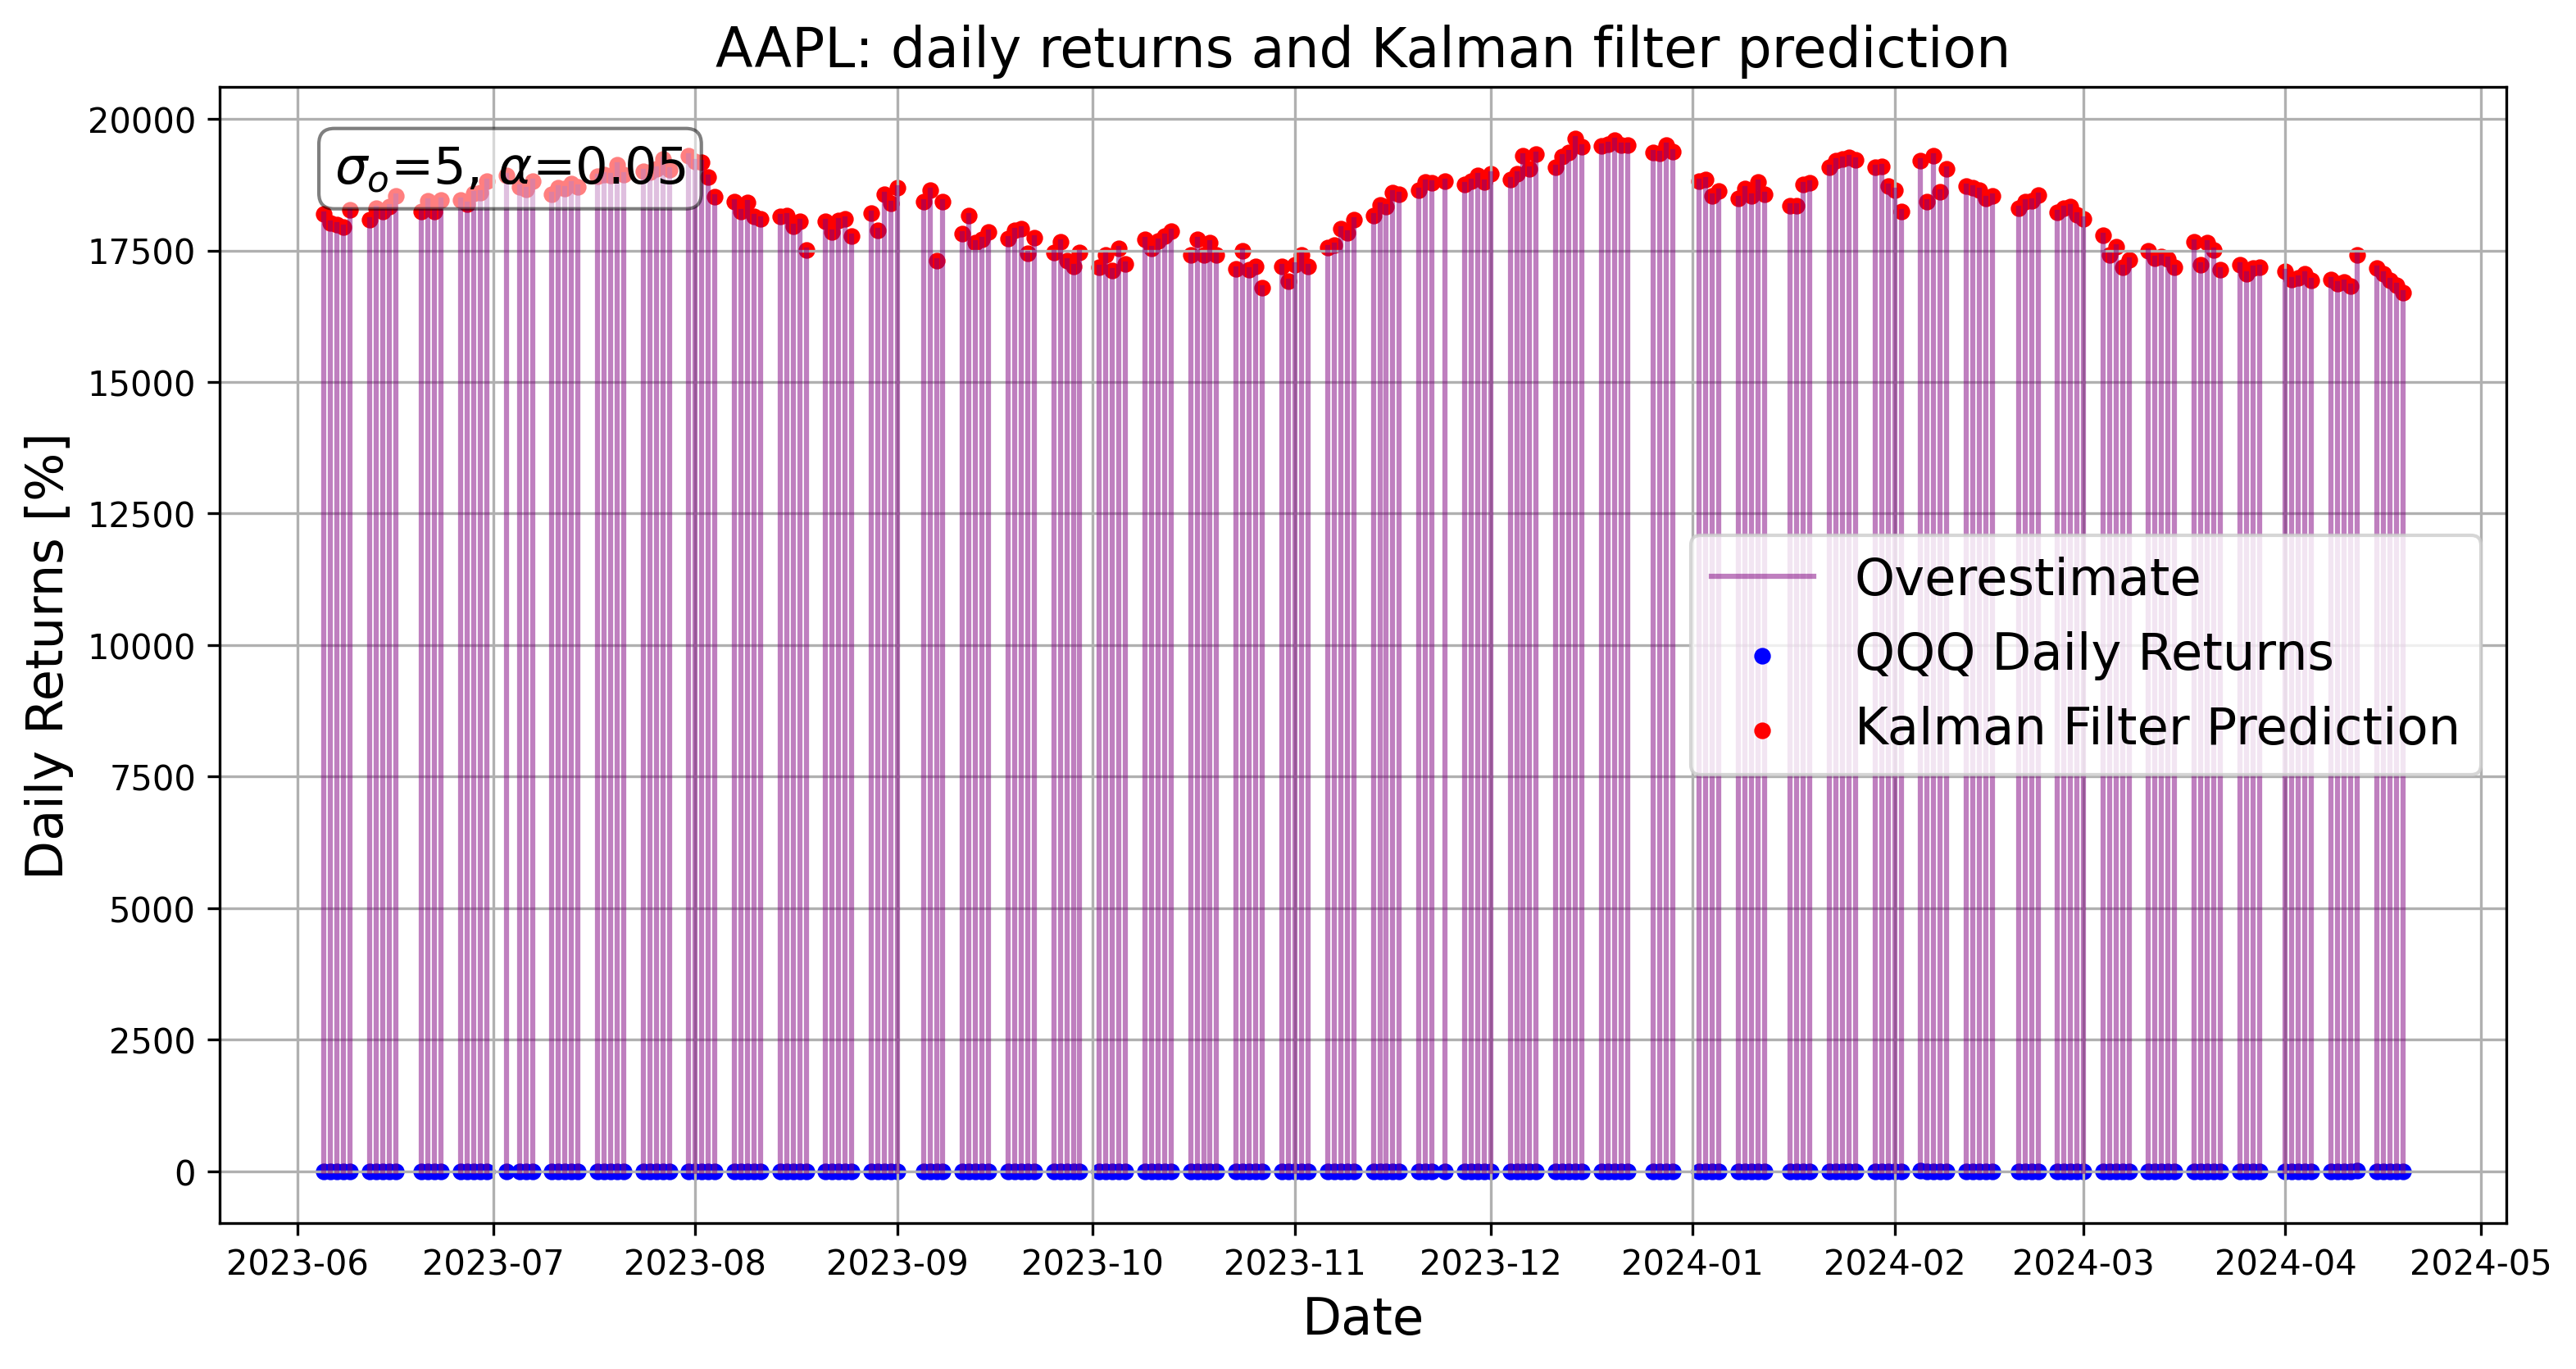

In [260]:
plt.figure(figsize=(12, 6), dpi=300)

first_over = 0
first_under = 0
for i in range(len(data.index[start_index + 1:])):
    true = open_returns[start_index+i] *100
    kalman = Z[:,1][i]*100
    if true > kalman:
        if first_under == 0:
            plt.plot([data.index[start_index + 1+i], data.index[start_index + 1+i]], 
                     [kalman, true], color='green', alpha=0.5, label="Underestimate")
            first_under= 1
        else:
            plt.plot([data.index[start_index + 1+i], data.index[start_index + 1+i]], 
                     [kalman, true], color='green', alpha=0.5)
    else:
        if first_over == 0:
            plt.plot([data.index[start_index + 1+i], data.index[start_index + 1+i]], 
                     [kalman, true], color='purple', alpha=0.5, label="Overestimate")   
            first_over = 1
        else:
            plt.plot([data.index[start_index + 1+i], data.index[start_index + 1+i]], 
                     [kalman, true], color='purple', alpha=0.5)                    

plt.scatter(data.index[start_index + 1:], open_returns[start_index:]*100, s=15, label='QQQ Daily Returns',
            color='blue')
plt.scatter(data.index[start_index + 1:], Z[:,1]*100, s=15, label='Kalman Filter Prediction',color='red')

plt.title('AAPL: daily returns and Kalman filter prediction', size=16)
plt.text(0.05, 0.95, r'$\sigma_o$='+str(sigma_o)+r', $\alpha$='+str(alpha), transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.xlabel('Date', size=15)
plt.ylabel('Daily Returns [%]', size=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig("AAPL-returns-with-kalman-increasing-sigma.png", bbox_inches='tight')
plt.show()

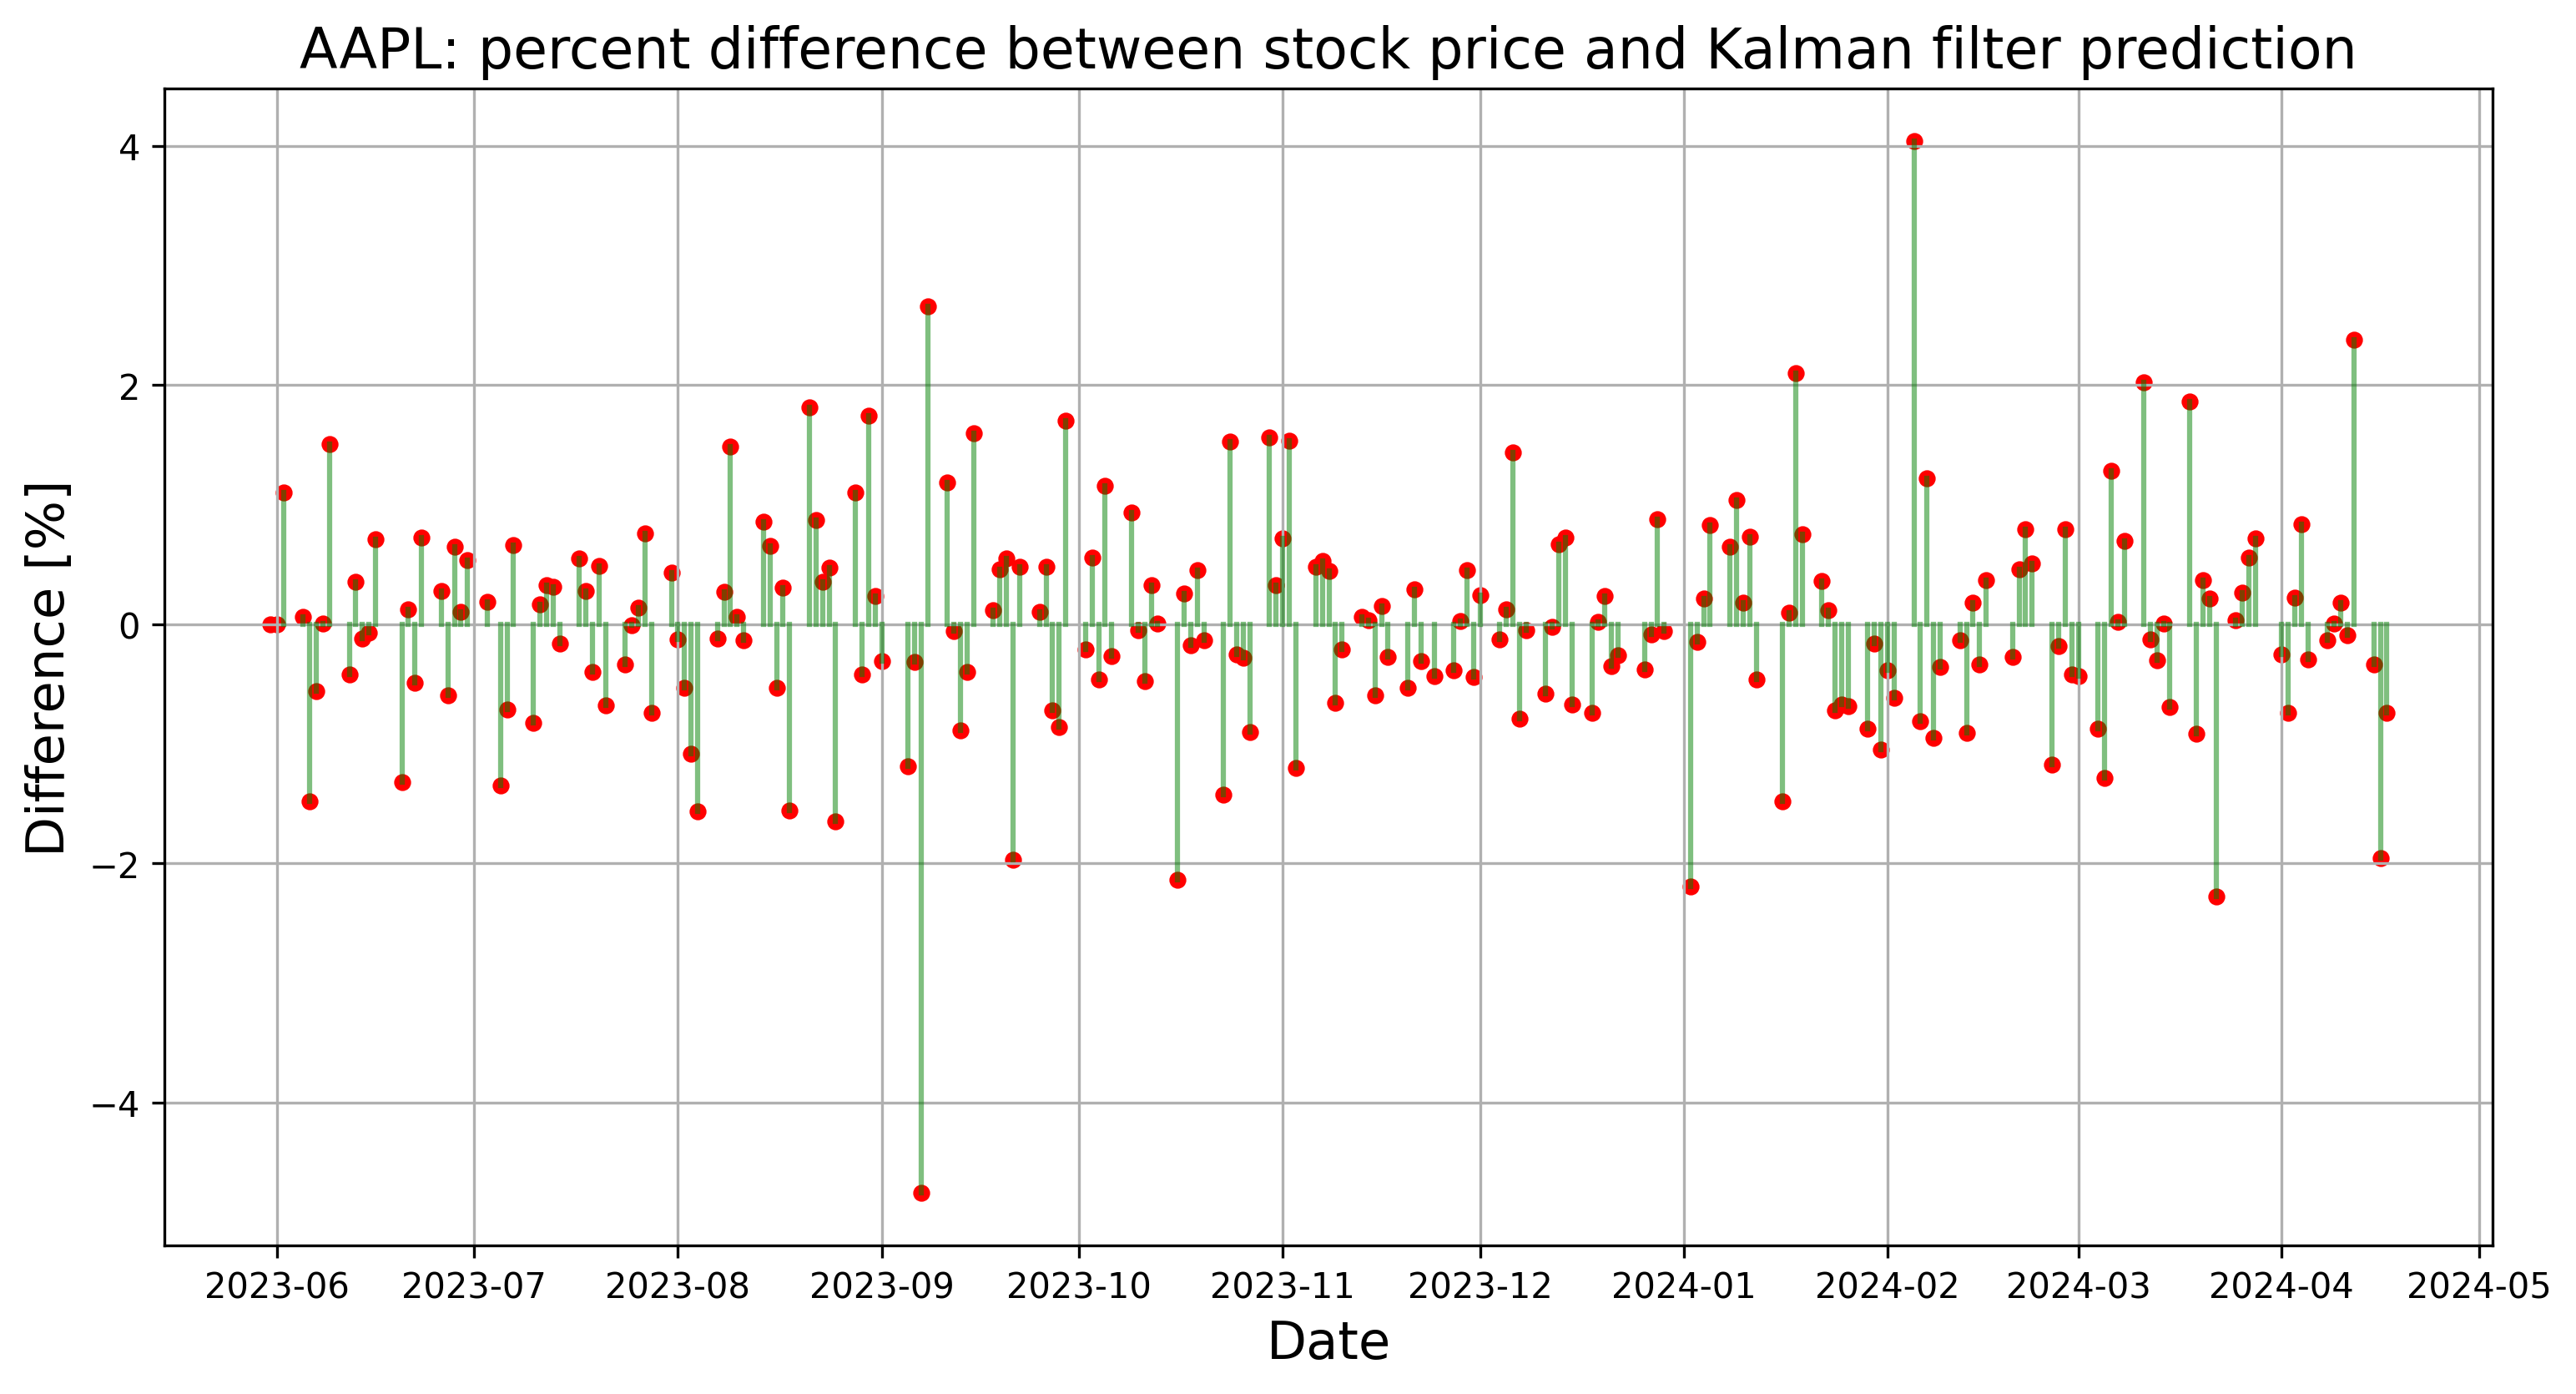

In [35]:
plt.figure(figsize=(12, 6), dpi=300)
difference = (open_returns[start_index:]-Z[:,1])*100
for i in range(len(data.index[start_index + 1:])):
        plt.plot([data.index[start_index + 1+i], data.index[start_index + 1+i]], 
                 [0, difference[i]], color='green', alpha=0.5)

plt.scatter(data.index[start_index + 1:], difference, s=15, label='Kalman Filter Prediction',color='red')
plt.title('AAPL: percent difference between stock price and Kalman filter prediction', size=16)
plt.xlabel('Date', size=15)
plt.ylabel('Difference [%]', size=15)
# plt.legend(fontsize=15)
plt.grid(True)
plt.savefig("price-vs-filter-diff.svg", bbox_inches='tight')
plt.show()


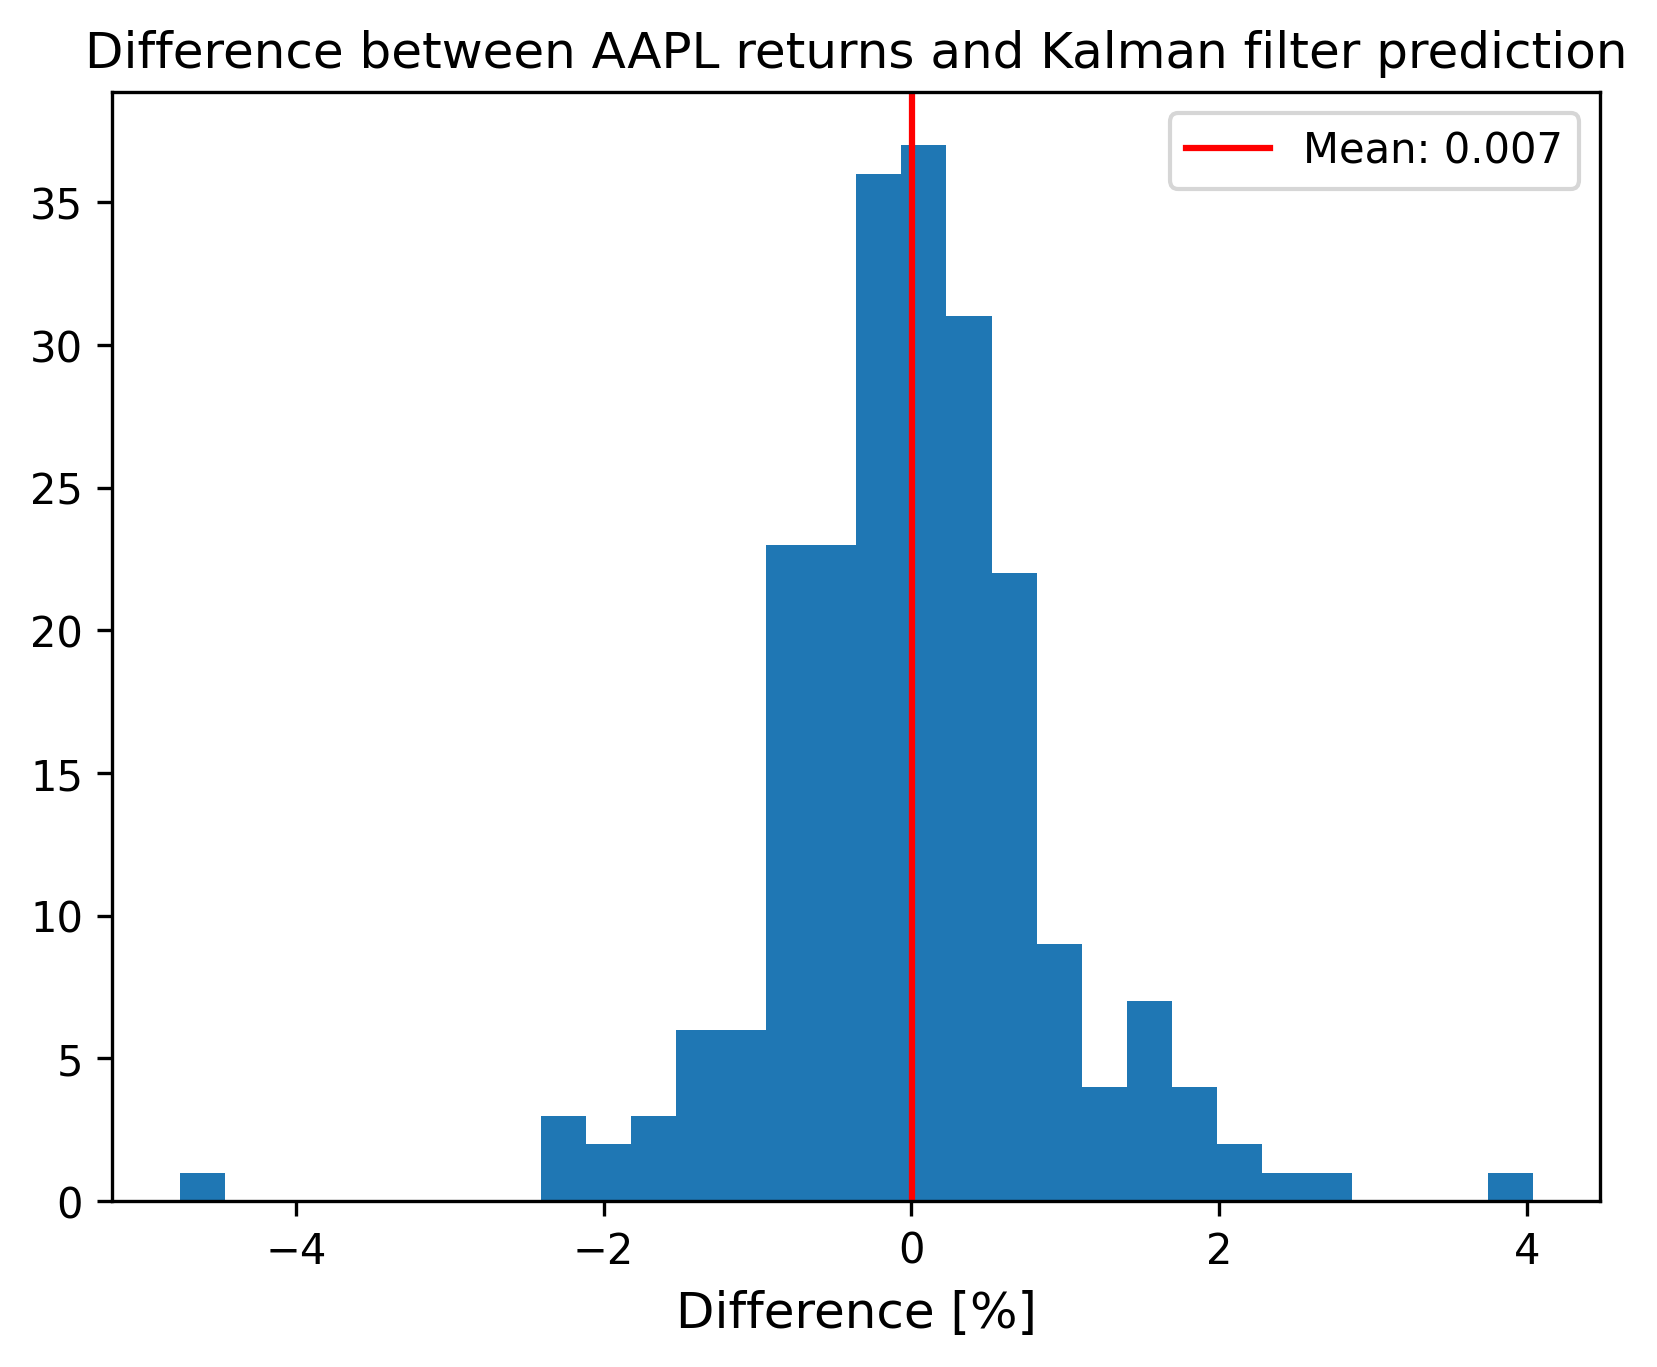

In [36]:
plt.figure(dpi=300)
plt.hist(difference, bins=30)
plt.axvline(np.mean(difference), color="red", label="Mean: "+str(round(np.mean(difference),3)))
plt.title("Difference between AAPL returns and Kalman filter prediction", size=12)
plt.xlabel("Difference [%]", size=12)
plt.legend()
plt.savefig("AAPL-difference-histogram.png", bbox_inches='tight')
plt.show()

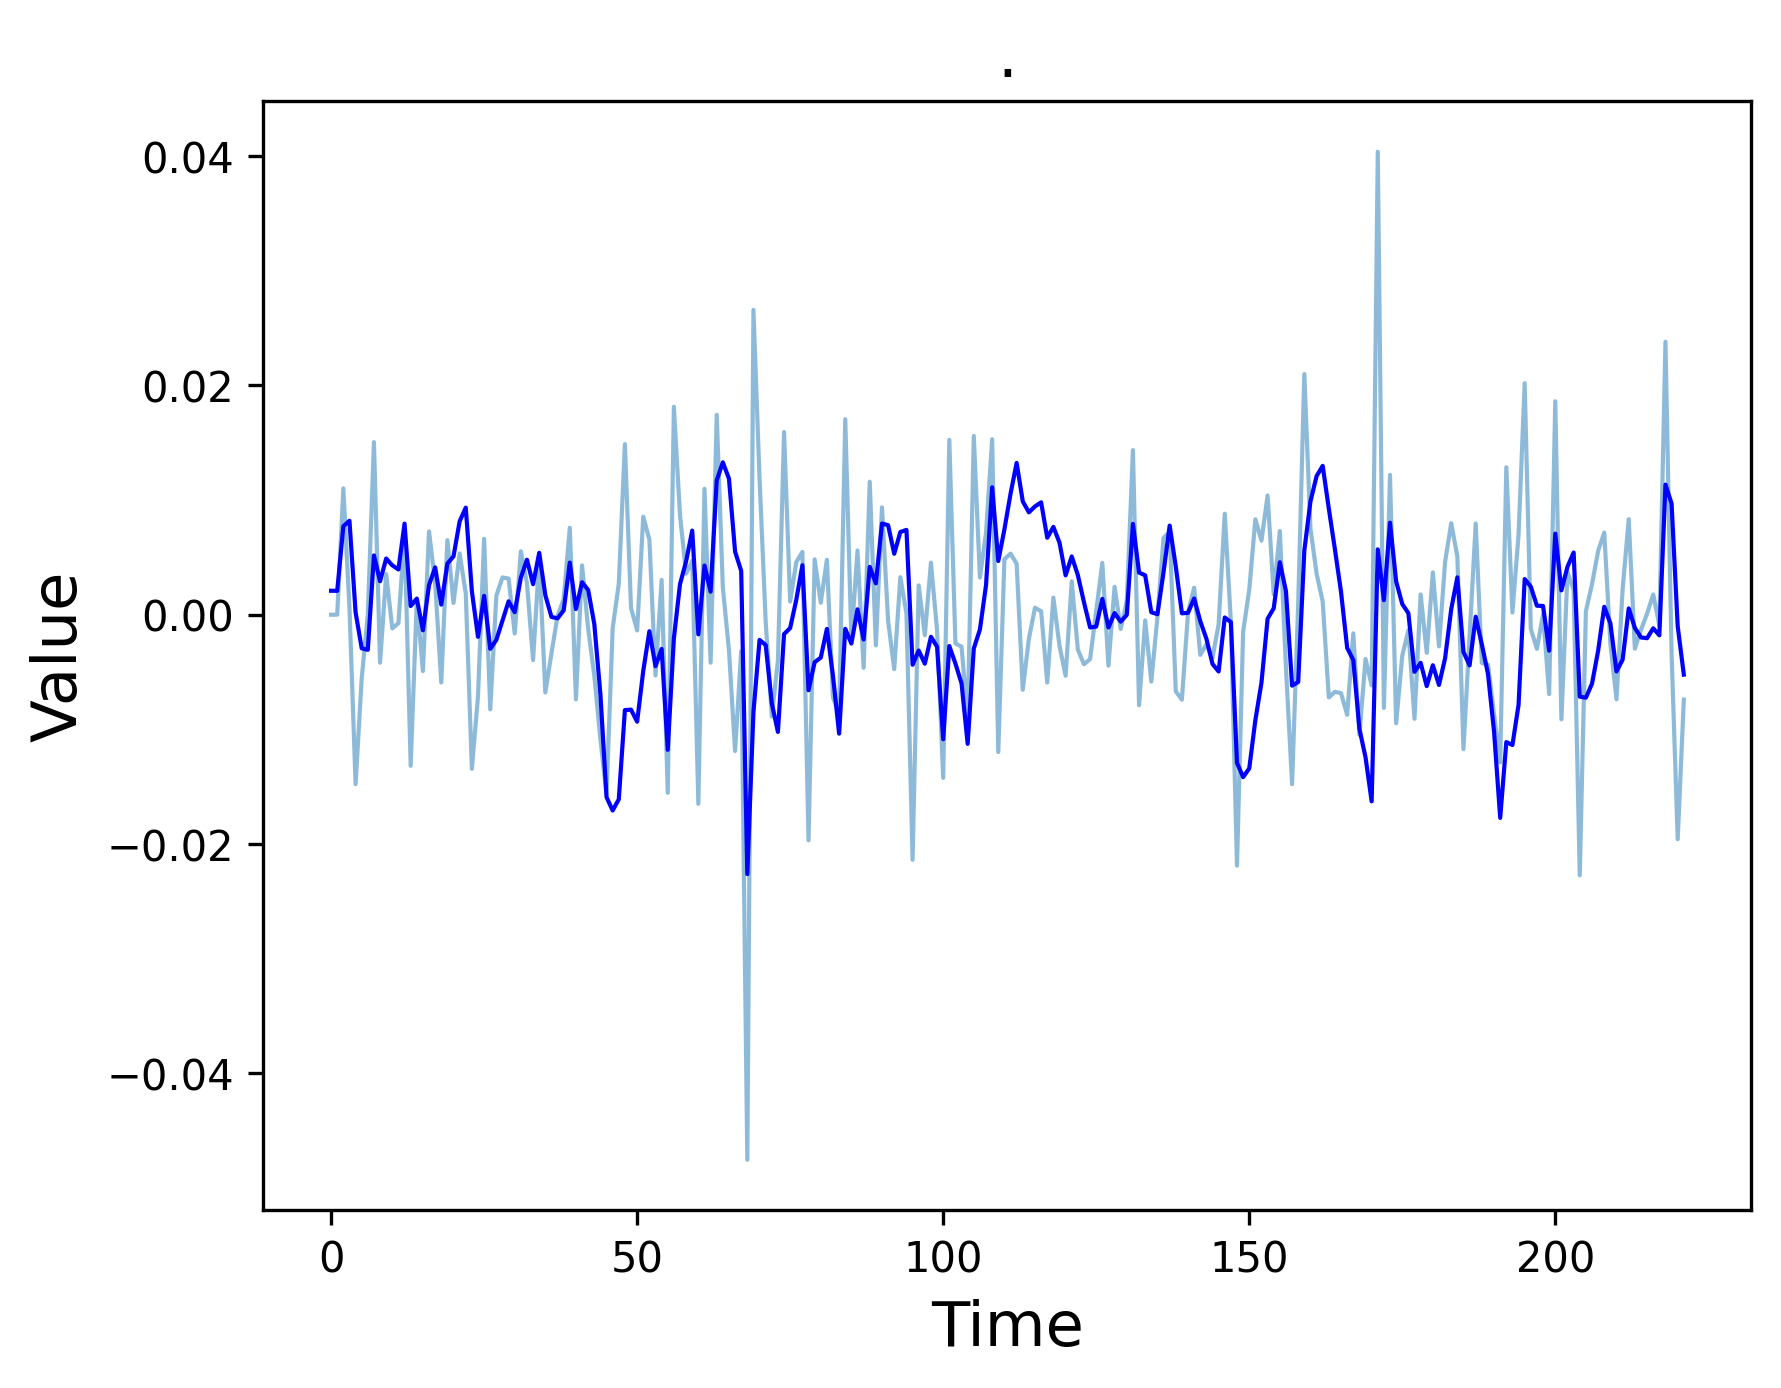

In [37]:
plt.figure(dpi=300)
plt.title(".", size=15)
plt.plot(time, Yt - Z[:,1], linewidth=1, label="Noisy Process", alpha=0.5)
plt.plot(time, Z[:,1], linewidth=1, label="Kalman Filter", color="blue")
# plt.plot(time, Xt, linewidth=1, label="True Process", color="red")
plt.xlabel("Time", size=15)
plt.ylabel("Value", size=15)
# plt.legend(fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(np.linspace(0.25,2.25,5),fontsize=15)
# plt.savefig("kalman-on-OU.png",bbox_inches='tight')
plt.show()

In [44]:
len(open_returns)

252

/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3798373533.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start_price = open_prices[start_index] # + open_prices[start_index] *np.cumsum(Z[:, 1])
/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3798373533.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  open_price = open_prices[start_index+i+1]
/var/folders/cg/1xzg2n596716fvvpmnqdcyhh0000gn/T/ipykernel_842/3798373533.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

180.31792261984526 181.91163262155055
181.91163262155055 180.20401700553845
179.26210155608032 179.84429587877156
177.73810077247185 179.4518936424621
177.20021515898222 182.67691312749454
180.78606868225572 180.76680858397822
180.55698564464774 183.08549264835509
182.08095504969188 182.38794000300297
182.64870479112247 183.3084844006158
183.23639618928618 185.29561924901037
185.99548959169113 182.35763860670409
183.68462630132845 184.38924814634217
184.17267884766156 182.38069977838217
183.01726350796105 184.60332331056085
184.8201339508181 184.55740898752313
186.09510581331676 183.84102743974557
185.1587891232395 185.80428736109405
187.1907544918752 186.05779474975878
188.33624985342487 188.11665846982328
190.87622407994112 189.1868993126296
193.01777233768289 187.0308630484035
190.81646927169217 186.56717447742105
189.09325926868843 188.16557504361822
190.65708636446033 185.70654430903272
188.5155401723345 186.91663664953575
188.41594837791777 186.83575875427607
188.93388677529288 1

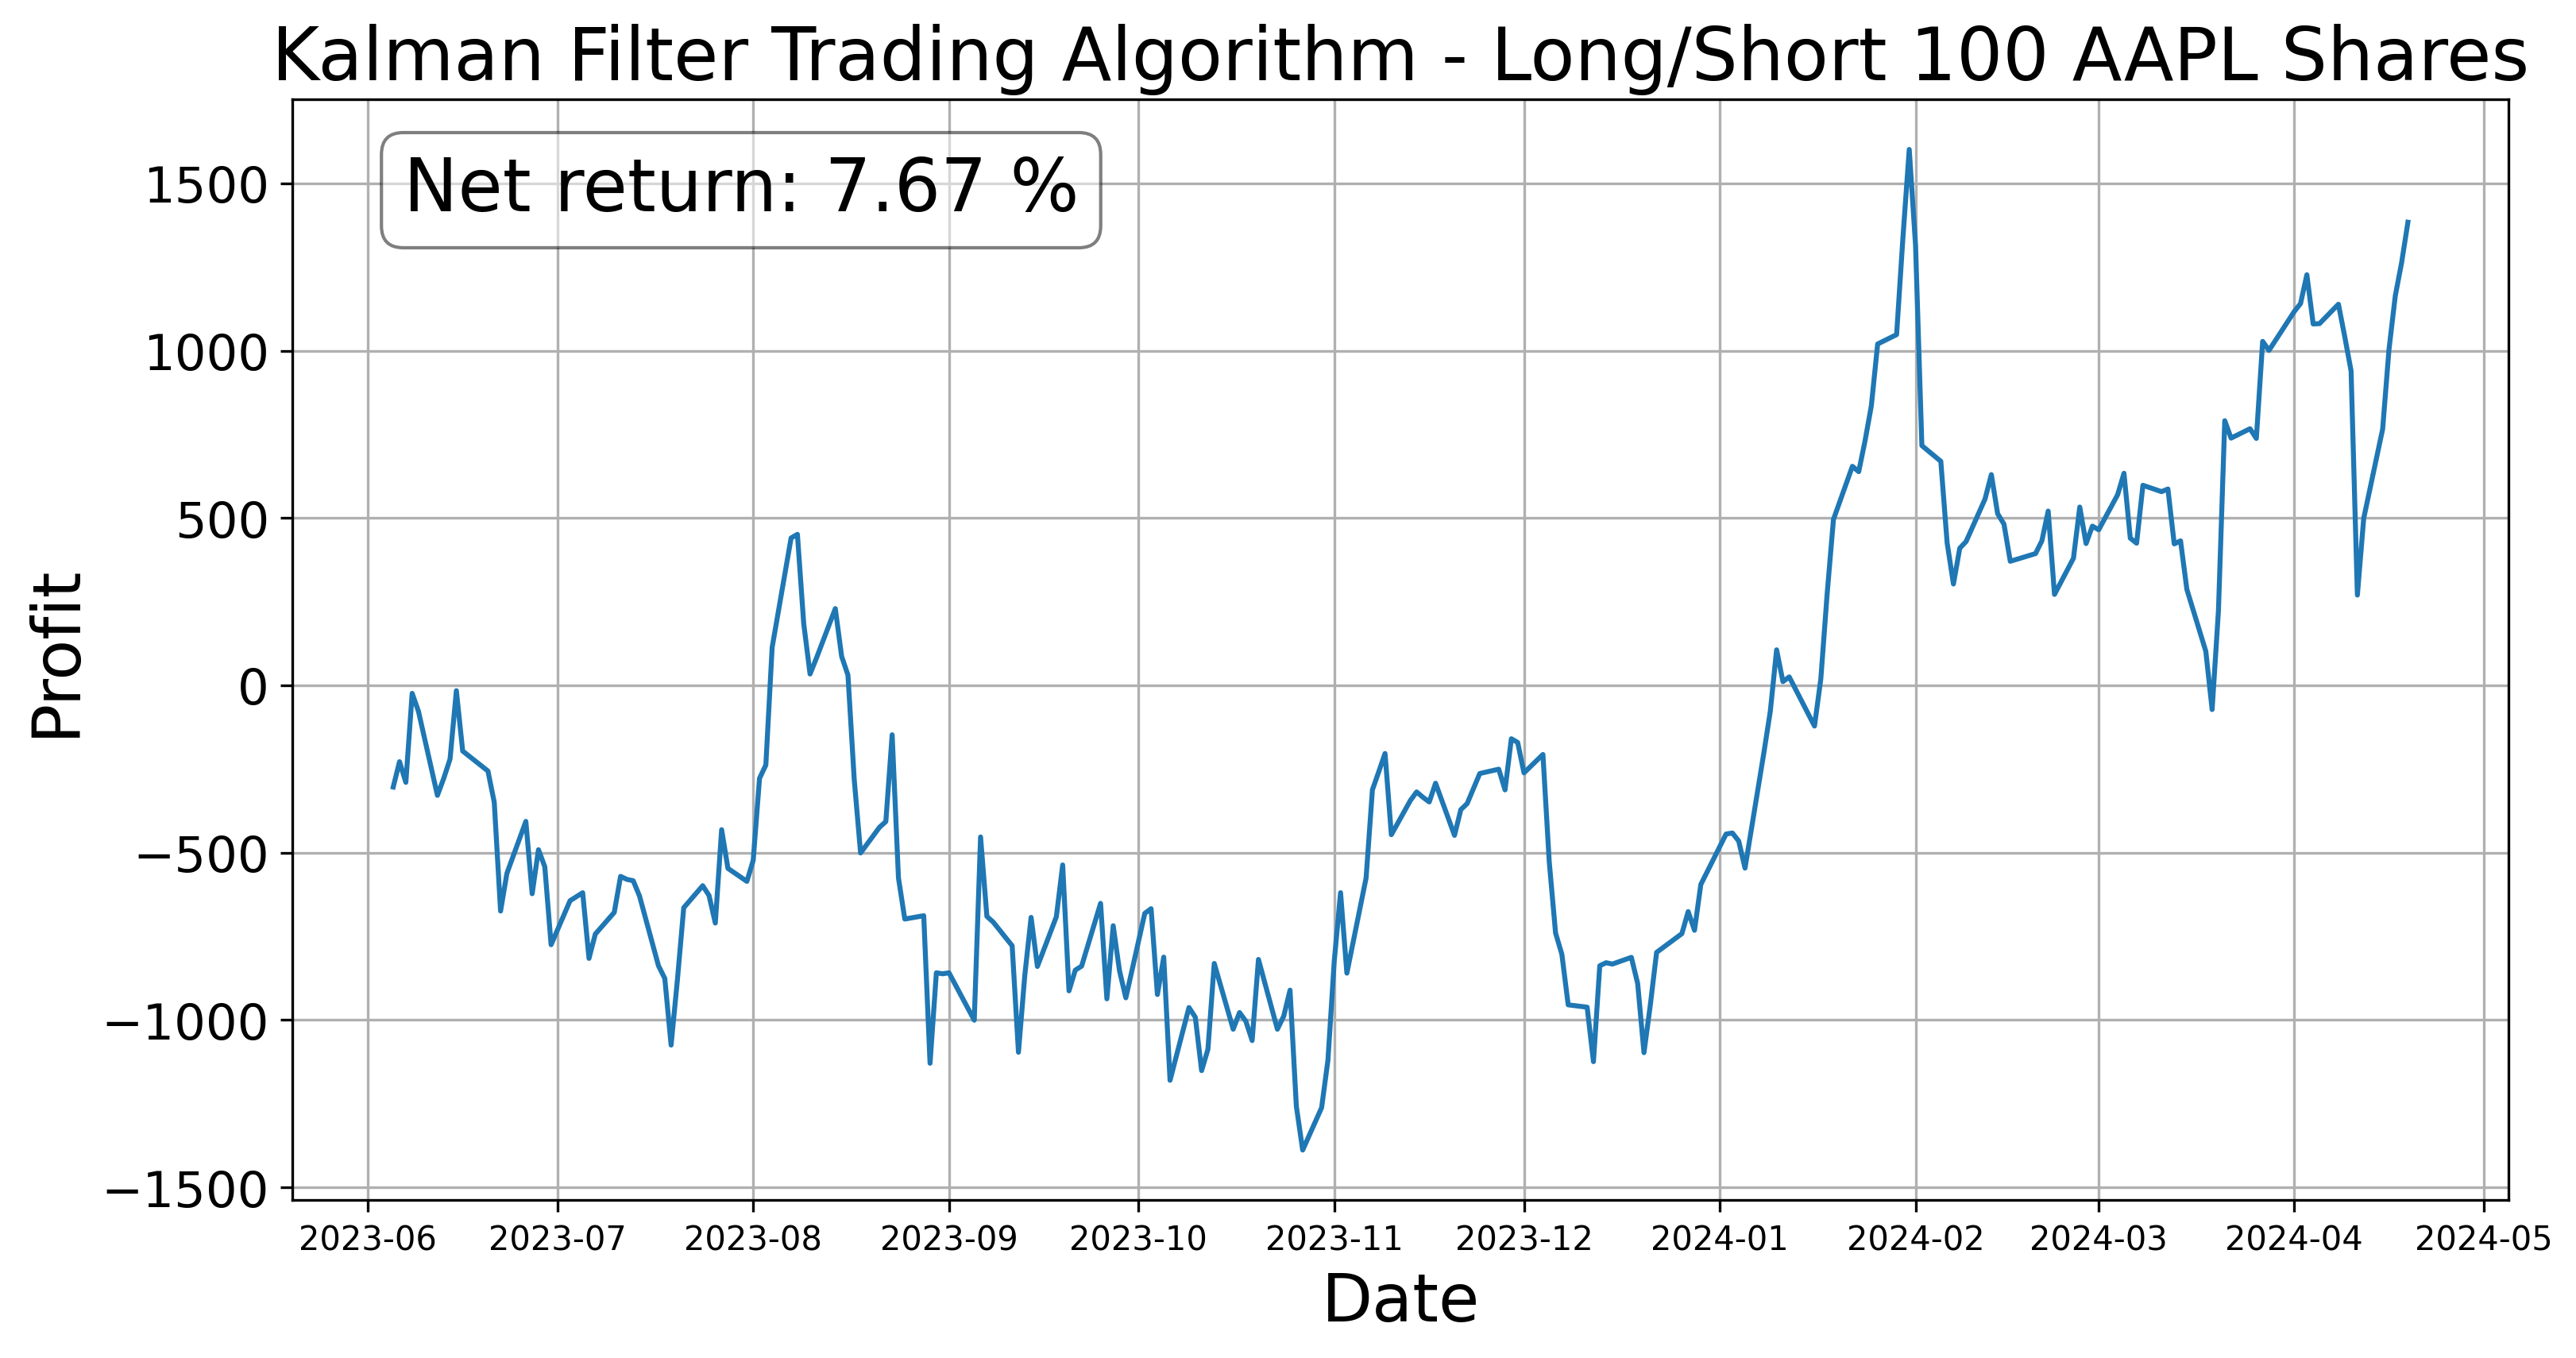

1383.7100169882629

In [259]:
# implementing trading algorithm
close_prices
profit = 0
profit_list = []
start_price = open_prices[start_index] # + open_prices[start_index] *np.cumsum(Z[:, 1])
capital = start_price * 100
for i in range(len(open_prices.index[start_index+1:])):
    date = open_prices.index[start_index+i+1]

    open_price = open_prices[start_index+i+1]
    close_price = close_prices[start_index+i+1]
    
    pred_return = Z[i,1]
    open_return = open_returns[start_index+i]
    open_return = open_prices[start_index+i]
    print(open_return, pred_return)
    if open_return < pred_return:
        profit += (close_price - open_price)*100
    else:
        profit += (open_price - close_price)*100
    profit_list.append(profit)


plt.figure(figsize=(12, 6), dpi=300)

# plt.scatter(data.index[start_index + 1:], difference, s=15, label='Kalman Filter Prediction',color='red')
plt.title('Kalman Filter Trading Algorithm - Long/Short 100 AAPL Shares', size=22)
plt.xlabel('Date', size=20)
plt.ylabel('Profit', size=20)
# plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(fontsize=15)
plt.grid(True)

returns = profit / capital * 100

plt.plot(open_prices.index[start_index+1:], profit_list)
plt.text(0.05, 0.95, r'Net return: '+str(round(returns,2))+" %", transform=plt.gca().transAxes, fontsize=22,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig("kalman-algorithm.png", bbox_inches='tight')

plt.show()

profit

1.6780052909538017

In [262]:
# def kalman_filter(Xt, F, t, Q):
#     dt = t[1] - t[0]
#     Yt = np.zeros(len(Xt))
#     Pt = np.zeros(len(Xt))
#     Yt[0] = Xt[0]
#     Pt[0] = 0.01
#     sigma_meas = 0.1
#     for i in range(len(t)-1):
#         # (a priori) prediction step:
#         Pt[i+1] = F * Pt[i] * F + Q
#         K = Pt[i+1] / (Pt[i+1] + sigma_meas**2 / dt)
#         Yt[i+1] = F * Yt[i] + theta * (1-np.exp(-kappa * dt))
        
#         # (a posteriori) update step
#         Pt[i+1] = (1-K)*Pt[i+1]
#         Yt[i+1] = F*Yt[i+1] + K*(Xt[i+1]-F*Yt[i+1])

#     return Yt, Pt
# Yt, Pt = kalman_filter(Xt, np.exp(-kappa * dt), time, np.std(Xt))

# plt.figure(dpi=300)
# plt.plot(time, Yt, linewidth=1, label="Model")
# plt.plot(time, Xt, linewidth=1, label="Process")
# plt.legend()
# plt.show()

In [263]:
# import numpy as np

# def kalman_filter(Xt, Q, R, A, B, C, mu0, P0):
#     """
#     Kalman filter implementation for Ornstein-Uhlenbeck process.
    
#     Args:
#     - Xt: observed data (1D array)
#     - Q: process noise covariance matrix
#     - R: measurement noise covariance matrix
#     - A: state transition matrix
#     - B: control matrix
#     - C: observation matrix
#     - mu0: initial state estimate
#     - P0: initial error covariance matrix
    
#     Returns:
#     - filtered_state_means: array of filtered state means
#     - filtered_state_covariances: array of filtered state covariances
#     """
#     num_timesteps = len(Xt)
#     state_dim = len(mu0)
    
#     filtered_state_means = np.zeros((num_timesteps, state_dim))
#     filtered_state_covariances = np.zeros((num_timesteps, state_dim, state_dim))
    
#     # Initialization
#     mu_t = mu0
#     P_t = P0
    
#     for t in range(num_timesteps):
#         # Prediction step
#         mu_t_pred = np.dot(A, mu_t)
#         P_t_pred = np.dot(np.dot(A, P_t), A.T) + Q
        
#         # Update step
#         K_t = np.dot(np.dot(P_t_pred, C.T), np.linalg.inv(np.dot(np.dot(C, P_t_pred), C.T) + R))
#         mu_t = mu_t_pred + np.dot(K_t, Xt[t] - np.dot(C, mu_t_pred))
#         P_t = P_t_pred - np.dot(np.dot(K_t, C), P_t_pred)
        
#         filtered_state_means[t] = mu_t
#         filtered_state_covariances[t] = P_t
        
#     return filtered_state_means, filtered_state_covariances

# # Example usage
# # Define parameters
# Q = np.array([[0.001]])  # Process noise covariance
# R = np.array([[0.01]])   # Measurement noise covariance
# A = np.array([[1]])       # State transition matrix
# B = np.array([[0]])       # Control matrix (not used in this example)
# C = np.array([[1]])       # Observation matrix
# mu0 = np.array([0])       # Initial state estimate
# P0 = np.array([[0.1]])    # Initial error covariance matrix

# # Generate example data
# np.random.seed(0)
# T = 100
# Xt = np.zeros(T)
# Xt[0] = 0
# theta = 0.1
# for t in range(1, T):
#     Xt[t] = Xt[t-1] + theta * (0 - Xt[t-1]) + np.random.normal(0, np.sqrt(0.001))

# # Apply Kalman filter
# filtered_state_means, filtered_state_covariances = kalman_filter(Xt, Q, R, A, B, C, mu0, P0)

# # Plot results
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(range(T), Xt, label='Observed')
# plt.plot(range(T), filtered_state_means[:, 0], label='Filtered', color='red')
# plt.fill_between(range(T),
#                  filtered_state_means[:, 0] - 2*np.sqrt(filtered_state_covariances[:, 0, 0]),
#                  filtered_state_means[:, 0] + 2*np.sqrt(filtered_state_covariances[:, 0, 0]),
#                  color='red', alpha=0.2)
# plt.title('Kalman Filter Applied to Ornstein-Uhlenbeck Process')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()


The (GBM) geometric brownian motion is described by the following SDE:   

$ dN_t = \mu N_t dt + \sigma N_t dW_t $   
The parameters are:  
- $\mu$: drift coefficient
- $\sigma$: volatility coefficient   

We simulate this process using the Euler-Maruyama scheme:   

(Derivation)

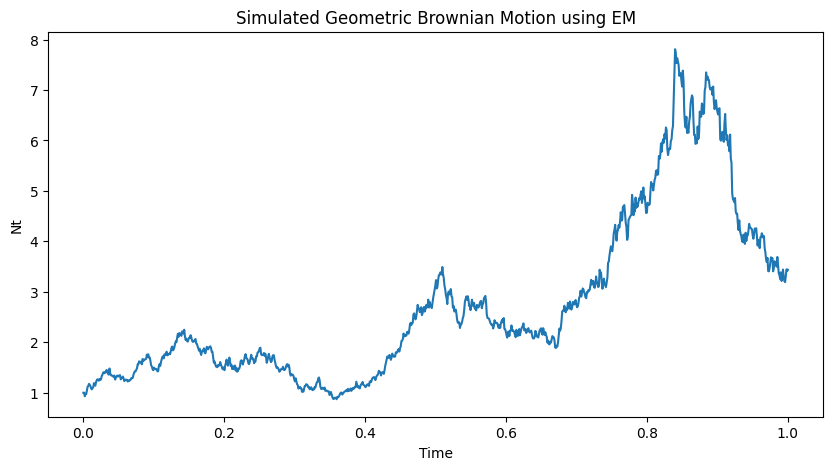

In [7]:
np.random.seed(seed=605)

mu = 1.0
sigma = 1.0
N0 = 1

T = 1 
N = 1000   
dt = T / N     
time = np.linspace(0, T, N)
Nt = np.zeros(N)

Nt[0] = X0

for t in range(1, N):
    dW = np.random.normal(0,np.sqrt(T / N)) 
    Nt[t] = Nt[t-1] + mu * Nt[t-1] * dt + sigma * Nt[t-1]* dW

plt.figure(figsize=(10, 5))
plt.plot(time, Nt)
plt.title('Simulated Geometric Brownian Motion using EM')
plt.xlabel('Time')
plt.ylabel('Nt')
plt.show()

Alternative method: simulate an OU process directtly from the solution:

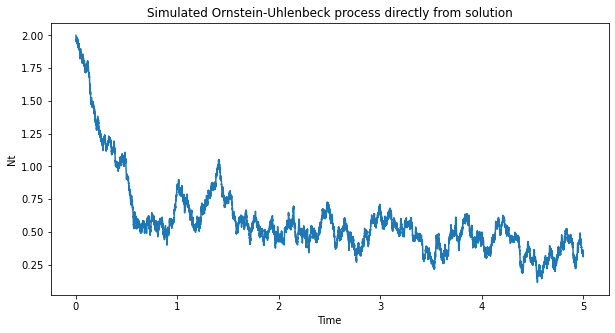

In [5]:
np.random.seed(seed=605)

N = 20000  
paths = 5000  
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 3
theta = 0.5
sigma = 0.5
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation

X0 = 2
X = np.zeros((N, paths))
X[0, :] = X0
W = np.random.normal(loc=0, scale=1, size=(N - 1, paths))

std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[t + 1, :] = theta + np.exp(-kappa * dt) * (X[t, :] - theta) + std_dt * W[t, :]

X_T = X[-1, :]  
X_1 = X[:, 1] 

plt.figure(figsize=(10, 5))
plt.plot(T_vec, X_1)
plt.title('Simulated Ornstein-Uhlenbeck process directly from solution')
plt.xlabel('Time')
plt.ylabel('Nt')
plt.show()

Regard the above as the true state space, we add some noise to this process and regrad it as an observation process：

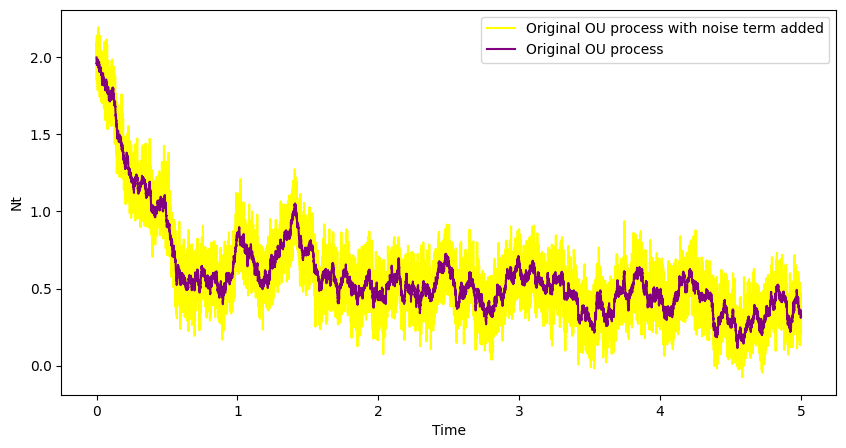

In [32]:
sig_eps = 0.1
eps = np.random.normal(loc = 0, scale =  sig_eps, size = N)
Y_1 = X_1 + eps

plt.figure(figsize=(10, 5))

plt.plot(T_vec, Y_1, label="Original OU process with noise term added",color = "yellow")
plt.plot(T_vec, X_1, label="Original OU process",color = "purple")

plt.xlabel("Time")
plt.ylabel("Nt")
plt.legend() 
plt.show()